In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.ndimage import gaussian_filter1d
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class StockNoiseReducer:
    def __init__(self, symbols=None):
        """
        Initialize with FTSE 100 financial stock symbols
        """
        if symbols is None:
            # Major FTSE 100 Financial stocks
            self.symbols = [
                'HSBA.L',   # HSBC Holdings
                'BARC.L',   # Barclays
                'LLOY.L',   # Lloyds Banking Group
                'NWG.L',    # NatWest Group
                'STAN.L',   # Standard Chartered
                'AV.L',     # Aviva
                'LGEN.L',   # Legal & General
                'PRU.L'     # Prudential
            ]
        else:
            self.symbols = symbols
        
        self.data = {}
        self.processed_data = {}
    
    def fetch_data(self, period='6mo', interval='1d'):
        """
        Fetch stock data for analysis
        """
        print("Fetching stock data...")
        for symbol in self.symbols:
            try:
                ticker = yf.Ticker(symbol)
                df = ticker.history(period=period, interval=interval)
                if not df.empty:
                    self.data[symbol] = df
                    print(f"✓ Downloaded {symbol}: {len(df)} records")
                else:
                    print(f"✗ No data for {symbol}")
            except Exception as e:
                print(f"✗ Error downloading {symbol}: {str(e)}")
    
    def apply_noise_reduction(self):
        """
        Apply various noise reduction techniques
        """
        print("\nApplying noise reduction techniques...")
        
        for symbol in self.data.keys():
            df = self.data[symbol].copy()
            processed = pd.DataFrame(index=df.index)
            
            # Original price data
            processed['Close_Original'] = df['Close']
            processed['Volume_Original'] = df['Volume']
            
            # 1. Log Transform
            processed['Close_LogTransform'] = np.log(df['Close'])
            
            # 2. First Order Derivative (Price Changes)
            processed['Close_FirstDerivative'] = df['Close'].diff()
            processed['Close_PctChange'] = df['Close'].pct_change()
            
            # 3. Moving Average Smoothing
            processed['Close_MA5'] = df['Close'].rolling(window=5, center=True).mean()
            processed['Close_MA10'] = df['Close'].rolling(window=10, center=True).mean()
            processed['Close_EMA8'] = df['Close'].ewm(span=8).mean()
            
            # 4. Gaussian Filter (Smooth noise reduction)
            processed['Close_Gaussian'] = pd.Series(
                gaussian_filter1d(df['Close'].values, sigma=1.0),
                index=df.index
            )
            
            # 5. Savitzky-Golay Filter (Preserves peaks better)
            if len(df) > 11:  # Need enough points for filter
                processed['Close_SavGol'] = pd.Series(
                    signal.savgol_filter(df['Close'].values, window_length=11, polyorder=3),
                    index=df.index
                )
            
            # 6. Z-Score Normalization
            processed['Close_ZScore'] = (df['Close'] - df['Close'].mean()) / df['Close'].std()
            
            # 7. Bollinger Bands Denoising
            bb_period = 20
            bb_std = 2
            sma = df['Close'].rolling(window=bb_period).mean()
            std = df['Close'].rolling(window=bb_period).std()
            processed['BB_Upper'] = sma + (std * bb_std)
            processed['BB_Lower'] = sma - (std * bb_std)
            processed['BB_Middle'] = sma
            
            # Constrain price within Bollinger Bands as noise reduction
            processed['Close_BB_Constrained'] = df['Close'].clip(
                lower=processed['BB_Lower'], 
                upper=processed['BB_Upper']
            )
            
            # 8. Median Filter (Remove outliers)
            processed['Close_Median5'] = df['Close'].rolling(window=5, center=True).median()
            
            # 9. High-Low Average (Reduces intraday noise)
            processed['HL_Average'] = (df['High'] + df['Low']) / 2
            processed['OHLC_Average'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4
            
            self.processed_data[symbol] = processed
            print(f"✓ Processed {symbol}")
    
    def calculate_noise_metrics(self):
        """
        Calculate metrics to compare original vs processed data
        """
        metrics = {}
        
        for symbol in self.processed_data.keys():
            df = self.processed_data[symbol]
            
            # Calculate various noise/volatility metrics
            symbol_metrics = {}
            
            methods = [
                'Close_Original', 'Close_LogTransform', 'Close_MA5', 'Close_MA10',
                'Close_EMA8', 'Close_Gaussian', 'Close_SavGol', 'Close_Median5',
                'Close_BB_Constrained', 'HL_Average', 'OHLC_Average'
            ]
            
            for method in methods:
                if method in df.columns and not df[method].isna().all():
                    data_series = df[method].dropna()
                    
                    # Standard Deviation (Volatility)
                    symbol_metrics[f'{method}_StdDev'] = data_series.std()
                    
                    # Coefficient of Variation
                    if data_series.mean() != 0:
                        symbol_metrics[f'{method}_CV'] = data_series.std() / abs(data_series.mean())
                    
                    # Mean Absolute Deviation
                    symbol_metrics[f'{method}_MAD'] = np.mean(abs(data_series - data_series.mean()))
                    
                    # Range (Max - Min)
                    symbol_metrics[f'{method}_Range'] = data_series.max() - data_series.min()
                    
                    # Autocorrelation (measure of randomness)
                    if len(data_series) > 1:
                        symbol_metrics[f'{method}_Autocorr'] = data_series.autocorr(lag=1)
            
            metrics[symbol] = symbol_metrics
        
        return metrics
    
    def visualize_comparison(self, symbol=None, save_plots=False):
        """
        Create visualizations comparing original vs processed data
        """
        if symbol is None:
            symbol = list(self.processed_data.keys())[0]
        
        df = self.processed_data[symbol]
        
        # Create subplots
        fig, axes = plt.subplots(3, 2, figsize=(15, 12))
        fig.suptitle(f'Noise Reduction Analysis - {symbol}', fontsize=16, fontweight='bold')
        
        # Plot 1: Original vs Moving Averages
        axes[0,0].plot(df.index, df['Close_Original'], label='Original', alpha=0.7, linewidth=1)
        axes[0,0].plot(df.index, df['Close_MA5'], label='MA-5', linewidth=2)
        axes[0,0].plot(df.index, df['Close_MA10'], label='MA-10', linewidth=2)
        axes[0,0].plot(df.index, df['Close_EMA8'], label='EMA-8', linewidth=2)
        axes[0,0].set_title('Moving Average Smoothing')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # Plot 2: Original vs Advanced Filters
        axes[0,1].plot(df.index, df['Close_Original'], label='Original', alpha=0.7, linewidth=1)
        axes[0,1].plot(df.index, df['Close_Gaussian'], label='Gaussian Filter', linewidth=2)
        if 'Close_SavGol' in df.columns:
            axes[0,1].plot(df.index, df['Close_SavGol'], label='Savitzky-Golay', linewidth=2)
        axes[0,1].plot(df.index, df['Close_Median5'], label='Median Filter', linewidth=2)
        axes[0,1].set_title('Advanced Filtering')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # Plot 3: Bollinger Bands Denoising
        axes[1,0].plot(df.index, df['Close_Original'], label='Original', alpha=0.7)
        axes[1,0].plot(df.index, df['BB_Upper'], label='BB Upper', linestyle='--', alpha=0.5)
        axes[1,0].plot(df.index, df['BB_Lower'], label='BB Lower', linestyle='--', alpha=0.5)
        axes[1,0].plot(df.index, df['BB_Middle'], label='BB Middle', linewidth=2)
        axes[1,0].plot(df.index, df['Close_BB_Constrained'], label='BB Constrained', linewidth=2)
        axes[1,0].fill_between(df.index, df['BB_Lower'], df['BB_Upper'], alpha=0.1)
        axes[1,0].set_title('Bollinger Bands Denoising')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        
        # Plot 4: Price Derivatives
        # axes[1,1].plot(df.index, df['Close_Original'], label='Close_Original', alpha=0.7)
        axes[1,1].plot(df.index, df['Close_ZScore'], label='Z-Score Normalized', linewidth=2)
        axes[1,1].plot(df.index, df['Close_FirstDerivative'], label='First Derivative', alpha=0.7)
        axes[1,1].plot(df.index, df['Close_PctChange'], label='Percentage Change', alpha=0.7)
        axes[1,1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
        axes[1,1].set_title('Price Derivatives')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        
        # Plot 5: Alternative Price Representations
        axes[2,0].plot(df.index, df['Close_Original'], label='Close', alpha=0.7)
        axes[2,0].plot(df.index, df['HL_Average'], label='High-Low Average', linewidth=2)
        axes[2,0].plot(df.index, df['OHLC_Average'], label='OHLC Average', linewidth=2)
        axes[2,0].set_title('Alternative Price Representations')
        axes[2,0].legend()
        axes[2,0].grid(True, alpha=0.3)
        
        # Plot 6: Normalized Comparison
        axes[2,1].plot(df.index, df['Close_ZScore'], label='Z-Score Normalized', linewidth=2)
        axes[2,1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
        axes[2,1].axhline(y=2, color='orange', linestyle='--', alpha=0.5, label='±2σ')
        axes[2,1].axhline(y=-2, color='orange', linestyle='--', alpha=0.5)
        axes[2,1].set_title('Z-Score Normalization')
        axes[2,1].legend()
        axes[2,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_plots:
            plt.savefig(f'{symbol}_noise_reduction_analysis.png', dpi=300, bbox_inches='tight')
        
        plt.show()
    
    def generate_summary_report(self):
        """
        Generate a comprehensive summary report
        """
        metrics = self.calculate_noise_metrics()
        
        print("\n" + "="*80)
        print("STOCK NOISE REDUCTION ANALYSIS REPORT")
        print("="*80)
        
        for symbol in metrics.keys():
            print(f"\n📊 {symbol} Analysis:")
            print("-" * 50)
            
            symbol_data = metrics[symbol]
            
            # Compare volatility reduction
            original_std = symbol_data.get('Close_Original_StdDev', 0)
            
            methods_comparison = {
                'Moving Average (5)': symbol_data.get('Close_MA5_StdDev', 0),
                'Moving Average (10)': symbol_data.get('Close_MA10_StdDev', 0),
                'Exponential MA (8)': symbol_data.get('Close_EMA8_StdDev', 0),
                'Gaussian Filter': symbol_data.get('Close_Gaussian_StdDev', 0),
                'Median Filter': symbol_data.get('Close_Median5_StdDev', 0),
                'BB Constrained': symbol_data.get('Close_BB_Constrained_StdDev', 0),
                'HL Average': symbol_data.get('HL_Average_StdDev', 0),
                'OHLC Average': symbol_data.get('OHLC_Average_StdDev', 0)
            }
            
            print(f"Original Volatility (Std Dev): {original_std:.4f}")
            print("\nNoise Reduction Effectiveness:")
            
            for method, std_dev in methods_comparison.items():
                if std_dev > 0:
                    reduction = ((original_std - std_dev) / original_std) * 100
                    print(f"  {method:20s}: {std_dev:.4f} ({reduction:+.1f}% change)")
            
            # Autocorrelation comparison
            print(f"\nAutocorrelation (Original): {symbol_data.get('Close_Original_Autocorr', 0):.4f}")
            
        print("\n" + "="*80)
        print("RECOMMENDATIONS:")
        print("="*80)
        print("1. Moving Averages: Good for trend following, removes high-frequency noise")
        print("2. Gaussian Filter: Smooth noise reduction, preserves overall shape")
        print("3. Median Filter: Excellent for removing outliers and spikes")
        print("4. Bollinger Bands: Useful for identifying and constraining extreme movements")
        print("5. OHLC Average: Reduces intraday noise while preserving daily patterns")
        print("\nFor day trading models, consider combining multiple techniques")
        print("based on your specific prediction horizon and risk tolerance.")



In [15]:
class StockNoiseReducer:
    def __init__(self, symbols=None):
        """
        Initialize with FTSE 100 financial stock symbols
        """
        if symbols is None:
            # Major FTSE 100 Financial stocks
            self.symbols = [
                'HSBA.L',   # HSBC Holdings
                'BARC.L',   # Barclays
                'LLOY.L',   # Lloyds Banking Group
                'NWG.L',    # NatWest Group
                'STAN.L',   # Standard Chartered
                'AV.L',     # Aviva
                'LGEN.L',   # Legal & General
                'PRU.L'     # Prudential
            ]
        else:
            self.symbols = symbols
        
        self.data = {}
        self.processed_data = {}
    
    def fetch_data(self, period='6mo', interval='1d'):
        """
        Fetch stock data for analysis
        """
        print("Fetching stock data...")
        for symbol in self.symbols:
            try:
                ticker = yf.Ticker(symbol)
                df = ticker.history(period=period, interval=interval)
                if not df.empty:
                    self.data[symbol] = df
                    print(f"✓ Downloaded {symbol}: {len(df)} records")
                else:
                    print(f"✗ No data for {symbol}")
            except Exception as e:
                print(f"✗ Error downloading {symbol}: {str(e)}")
    
    def apply_noise_reduction(self):
        """
        Apply various noise reduction techniques
        """
        print("\nApplying noise reduction techniques...")
        
        for symbol in self.data.keys():
            df = self.data[symbol].copy()
            processed = pd.DataFrame(index=df.index)
            
            # Original price data
            processed['Close_Original'] = df['Close']
            processed['Volume_Original'] = df['Volume']
            
            # 1. Log Transform
            processed['Close_LogTransform'] = np.log(df['Close'])
            
            # 2. First and Second Order Derivatives (Price Changes and Acceleration)
            processed['Close_FirstDerivative'] = df['Close'].diff()
            processed['Close_PctChange'] = df['Close'].pct_change()
            
            # Second Order Derivative (Acceleration/Momentum changes)
            processed['Close_SecondDerivative'] = df['Close'].diff().diff()
            processed['Close_PctChange_Acceleration'] = df['Close'].pct_change().diff()
            
            # Smooth derivatives using different methods
            processed['Close_FirstDeriv_MA3'] = processed['Close_FirstDerivative'].rolling(window=3, center=True).mean()
            processed['Close_SecondDeriv_MA3'] = processed['Close_SecondDerivative'].rolling(window=3, center=True).mean()
            
            # Normalized derivatives (useful for comparing across different price levels)
            processed['Close_FirstDeriv_Normalized'] = processed['Close_FirstDerivative'] / df['Close'].shift(1)
            processed['Close_SecondDeriv_Normalized'] = processed['Close_SecondDerivative'] / df['Close'].shift(2)
            
            # 3. Moving Average Smoothing
            processed['Close_MA5'] = df['Close'].rolling(window=5, center=True).mean()
            processed['Close_MA10'] = df['Close'].rolling(window=10, center=True).mean()
            processed['Close_EMA8'] = df['Close'].ewm(span=8).mean()
            
            # 4. Gaussian Filter (Smooth noise reduction)
            processed['Close_Gaussian'] = pd.Series(
                gaussian_filter1d(df['Close'].values, sigma=1.0),
                index=df.index
            )
            
            # 5. Savitzky-Golay Filter (Preserves peaks better)
            if len(df) > 11:  # Need enough points for filter
                processed['Close_SavGol'] = pd.Series(
                    signal.savgol_filter(df['Close'].values, window_length=11, polyorder=3),
                    index=df.index
                )
            
            # 6. Z-Score Normalization
            processed['Close_ZScore'] = (df['Close'] - df['Close'].mean()) / df['Close'].std()
            
            # 7. Bollinger Bands Denoising
            bb_period = 20
            bb_std = 2
            sma = df['Close'].rolling(window=bb_period).mean()
            std = df['Close'].rolling(window=bb_period).std()
            processed['BB_Upper'] = sma + (std * bb_std)
            processed['BB_Lower'] = sma - (std * bb_std)
            processed['BB_Middle'] = sma
            
            # Constrain price within Bollinger Bands as noise reduction
            processed['Close_BB_Constrained'] = df['Close'].clip(
                lower=processed['BB_Lower'], 
                upper=processed['BB_Upper']
            )
            
            # 8. Median Filter (Remove outliers)
            processed['Close_Median5'] = df['Close'].rolling(window=5, center=True).median()
            
            # 9. High-Low Average (Reduces intraday noise)
            processed['HL_Average'] = (df['High'] + df['Low']) / 2
            processed['OHLC_Average'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4
            
            self.processed_data[symbol] = processed
            print(f"✓ Processed {symbol}")
    
    def calculate_noise_metrics(self):
        """
        Calculate metrics to compare original vs processed data
        """
        metrics = {}
        
        for symbol in self.processed_data.keys():
            df = self.processed_data[symbol]
            
            # Calculate various noise/volatility metrics
            symbol_metrics = {}
            
            methods = [
                'Close_Original', 'Close_LogTransform', 'Close_MA5', 'Close_MA10',
                'Close_EMA8', 'Close_Gaussian', 'Close_SavGol', 'Close_Median5',
                'Close_BB_Constrained', 'HL_Average', 'OHLC_Average',
                'Close_FirstDerivative', 'Close_SecondDerivative', 'Close_PctChange',
                'Close_PctChange_Acceleration', 'Close_FirstDeriv_MA3', 'Close_SecondDeriv_MA3'
            ]
            
            for method in methods:
                if method in df.columns and not df[method].isna().all():
                    data_series = df[method].dropna()
                    
                    # Standard Deviation (Volatility)
                    symbol_metrics[f'{method}_StdDev'] = data_series.std()
                    
                    # Coefficient of Variation
                    if data_series.mean() != 0:
                        symbol_metrics[f'{method}_CV'] = data_series.std() / abs(data_series.mean())
                    
                    # Mean Absolute Deviation
                    symbol_metrics[f'{method}_MAD'] = np.mean(abs(data_series - data_series.mean()))
                    
                    # Range (Max - Min)
                    symbol_metrics[f'{method}_Range'] = data_series.max() - data_series.min()
                    
                    # Autocorrelation (measure of randomness)
                    if len(data_series) > 1:
                        symbol_metrics[f'{method}_Autocorr'] = data_series.autocorr(lag=1)
            
            metrics[symbol] = symbol_metrics
        
        return metrics
    
    def visualize_comparison(self, symbol=None, save_plots=False):
        """
        Create visualizations comparing original vs processed data
        """
        if symbol is None:
            symbol = list(self.processed_data.keys())[0]
        
        df = self.processed_data[symbol]
        
        # Create subplots
        fig, axes = plt.subplots(3, 2, figsize=(15, 12))
        fig.suptitle(f'Noise Reduction Analysis - {symbol}', fontsize=16, fontweight='bold')
        
        # Plot 1: Original vs Moving Averages
        axes[0,0].plot(df.index, df['Close_Original'], label='Original', alpha=0.7, linewidth=1)
        axes[0,0].plot(df.index, df['Close_MA5'], label='MA-5', linewidth=2)
        axes[0,0].plot(df.index, df['Close_MA10'], label='MA-10', linewidth=2)
        axes[0,0].plot(df.index, df['Close_EMA8'], label='EMA-8', linewidth=2)
        axes[0,0].set_title('Moving Average Smoothing')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # Plot 2: Original vs Advanced Filters
        axes[0,1].plot(df.index, df['Close_Original'], label='Original', alpha=0.7, linewidth=1)
        axes[0,1].plot(df.index, df['Close_Gaussian'], label='Gaussian Filter', linewidth=2)
        if 'Close_SavGol' in df.columns:
            axes[0,1].plot(df.index, df['Close_SavGol'], label='Savitzky-Golay', linewidth=2)
        axes[0,1].plot(df.index, df['Close_Median5'], label='Median Filter', linewidth=2)
        axes[0,1].set_title('Advanced Filtering')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # Plot 3: Bollinger Bands Denoising
        axes[1,0].plot(df.index, df['Close_Original'], label='Original', alpha=0.7)
        axes[1,0].plot(df.index, df['BB_Upper'], label='BB Upper', linestyle='--', alpha=0.5)
        axes[1,0].plot(df.index, df['BB_Lower'], label='BB Lower', linestyle='--', alpha=0.5)
        axes[1,0].plot(df.index, df['BB_Middle'], label='BB Middle', linewidth=2)
        axes[1,0].plot(df.index, df['Close_BB_Constrained'], label='BB Constrained', linewidth=2)
        axes[1,0].fill_between(df.index, df['BB_Lower'], df['BB_Upper'], alpha=0.1)
        axes[1,0].set_title('Bollinger Bands Denoising')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        
        # Plot 4: Price Derivatives (Enhanced)
        axes[1,1].plot(df.index, df['Close_FirstDerivative'], label='1st Derivative', alpha=0.7)
        axes[1,1].plot(df.index, df['Close_SecondDerivative'], label='2nd Derivative', alpha=0.7)
        axes[1,1].plot(df.index, df['Close_FirstDeriv_MA3'], label='1st Deriv (Smoothed)', linewidth=2)
        axes[1,1].plot(df.index, df['Close_SecondDeriv_MA3'], label='2nd Deriv (Smoothed)', linewidth=2)
        axes[1,1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
        axes[1,1].set_title('Price Derivatives (1st & 2nd Order)')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        
        # Plot 5: Alternative Price Representations
        axes[2,0].plot(df.index, df['Close_Original'], label='Close', alpha=0.7)
        axes[2,0].plot(df.index, df['HL_Average'], label='High-Low Average', linewidth=2)
        axes[2,0].plot(df.index, df['OHLC_Average'], label='OHLC Average', linewidth=2)
        axes[2,0].set_title('Alternative Price Representations')
        axes[2,0].legend()
        axes[2,0].grid(True, alpha=0.3)
        
        # Plot 6: Normalized Derivatives Comparison
        axes[2,1].plot(df.index, df['Close_PctChange'], label='% Change (1st Deriv)', alpha=0.7)
        axes[2,1].plot(df.index, df['Close_PctChange_Acceleration'], label='% Change Acceleration', alpha=0.7)
        axes[2,1].plot(df.index, df['Close_FirstDeriv_Normalized'], label='1st Deriv Normalized', alpha=0.7)
        axes[2,1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
        axes[2,1].set_title('Normalized Derivatives Analysis')
        axes[2,1].legend()
        axes[2,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_plots:
            plt.savefig(f'{symbol}_noise_reduction_analysis.png', dpi=300, bbox_inches='tight')
        
        plt.show()
    
    def generate_summary_report(self):
        """
        Generate a comprehensive summary report
        """
        metrics = self.calculate_noise_metrics()
        
        print("\n" + "="*80)
        print("STOCK NOISE REDUCTION ANALYSIS REPORT")
        print("="*80)
        
        for symbol in metrics.keys():
            print(f"\n📊 {symbol} Analysis:")
            print("-" * 50)
            
            symbol_data = metrics[symbol]
            
            # Compare volatility reduction
            original_std = symbol_data.get('Close_Original_StdDev', 0)
            
            methods_comparison = {
                'Moving Average (5)': symbol_data.get('Close_MA5_StdDev', 0),
                'Moving Average (10)': symbol_data.get('Close_MA10_StdDev', 0),
                'Exponential MA (8)': symbol_data.get('Close_EMA8_StdDev', 0),
                'Gaussian Filter': symbol_data.get('Close_Gaussian_StdDev', 0),
                'Median Filter': symbol_data.get('Close_Median5_StdDev', 0),
                'BB Constrained': symbol_data.get('Close_BB_Constrained_StdDev', 0),
                'HL Average': symbol_data.get('HL_Average_StdDev', 0),
                'OHLC Average': symbol_data.get('OHLC_Average_StdDev', 0)
            }
            
            print(f"Original Volatility (Std Dev): {original_std:.4f}")
            print("\nNoise Reduction Effectiveness:")
            
            for method, std_dev in methods_comparison.items():
                if std_dev > 0:
                    reduction = ((original_std - std_dev) / original_std) * 100
                    print(f"  {method:20s}: {std_dev:.4f} ({reduction:+.1f}% change)")
            
            # Derivatives analysis
            print(f"\nDerivatives Analysis:")
            first_deriv_std = symbol_data.get('Close_FirstDerivative_StdDev', 0)
            second_deriv_std = symbol_data.get('Close_SecondDerivative_StdDev', 0)
            first_deriv_smooth_std = symbol_data.get('Close_FirstDeriv_MA3_StdDev', 0)
            second_deriv_smooth_std = symbol_data.get('Close_SecondDeriv_MA3_StdDev', 0)
            
            print(f"  1st Derivative Std Dev: {first_deriv_std:.4f}")
            print(f"  2nd Derivative Std Dev: {second_deriv_std:.4f}")
            if first_deriv_smooth_std > 0:
                smoothing_effect = ((first_deriv_std - first_deriv_smooth_std) / first_deriv_std) * 100
                print(f"  1st Deriv Smoothed: {first_deriv_smooth_std:.4f} ({smoothing_effect:+.1f}% smoother)")
            if second_deriv_smooth_std > 0:
                smoothing_effect2 = ((second_deriv_std - second_deriv_smooth_std) / second_deriv_std) * 100
                print(f"  2nd Deriv Smoothed: {second_deriv_smooth_std:.4f} ({smoothing_effect2:+.1f}% smoother)")
            
            # Autocorrelation comparison
            print(f"\nAutocorrelation Analysis:")
            print(f"  Original: {symbol_data.get('Close_Original_Autocorr', 0):.4f}")
            print(f"  1st Derivative: {symbol_data.get('Close_FirstDerivative_Autocorr', 0):.4f}")
            print(f"  2nd Derivative: {symbol_data.get('Close_SecondDerivative_Autocorr', 0):.4f}")
            
        print("\n" + "="*80)
        print("RECOMMENDATIONS:")
        print("="*80)
        print("1. Moving Averages: Good for trend following, removes high-frequency noise")
        print("2. Gaussian Filter: Smooth noise reduction, preserves overall shape")
        print("3. Median Filter: Excellent for removing outliers and spikes")
        print("4. Bollinger Bands: Useful for identifying and constraining extreme movements")
        print("5. OHLC Average: Reduces intraday noise while preserving daily patterns")
        print("6. First Derivative: Captures velocity/momentum - useful for trend changes")
        print("7. Second Derivative: Captures acceleration - useful for momentum shifts")
        print("8. Smoothed Derivatives: Combine derivative benefits with noise reduction")
        print("\nFor day trading models:")
        print("• Use 1st derivatives to capture price momentum")
        print("• Use 2nd derivatives to detect momentum acceleration/deceleration")
        print("• Smooth derivatives help reduce noise while preserving trend information")
        print("• Consider combining multiple techniques based on your prediction horizon")


Fetching stock data...
✓ Downloaded HSBA.L: 254 records
✓ Downloaded BARC.L: 254 records
✓ Downloaded LLOY.L: 254 records
✓ Downloaded NWG.L: 254 records
✓ Downloaded STAN.L: 254 records
✓ Downloaded AV.L: 254 records
✓ Downloaded LGEN.L: 254 records
✓ Downloaded PRU.L: 254 records

Applying noise reduction techniques...
✓ Processed HSBA.L
✓ Processed BARC.L
✓ Processed LLOY.L
✓ Processed NWG.L
✓ Processed STAN.L
✓ Processed AV.L
✓ Processed LGEN.L
✓ Processed PRU.L

STOCK NOISE REDUCTION ANALYSIS REPORT

📊 HSBA.L Analysis:
--------------------------------------------------
Original Volatility (Std Dev): 89.1599

Noise Reduction Effectiveness:
  Moving Average (5)  : 88.2038 (+1.1% change)
  Moving Average (10) : 87.0506 (+2.4% change)
  Exponential MA (8)  : 86.7234 (+2.7% change)
  Gaussian Filter     : 88.6933 (+0.5% change)
  Median Filter       : 88.3855 (+0.9% change)
  BB Constrained      : 89.0858 (+0.1% change)
  HL Average          : 88.6746 (+0.5% change)
  OHLC Average     

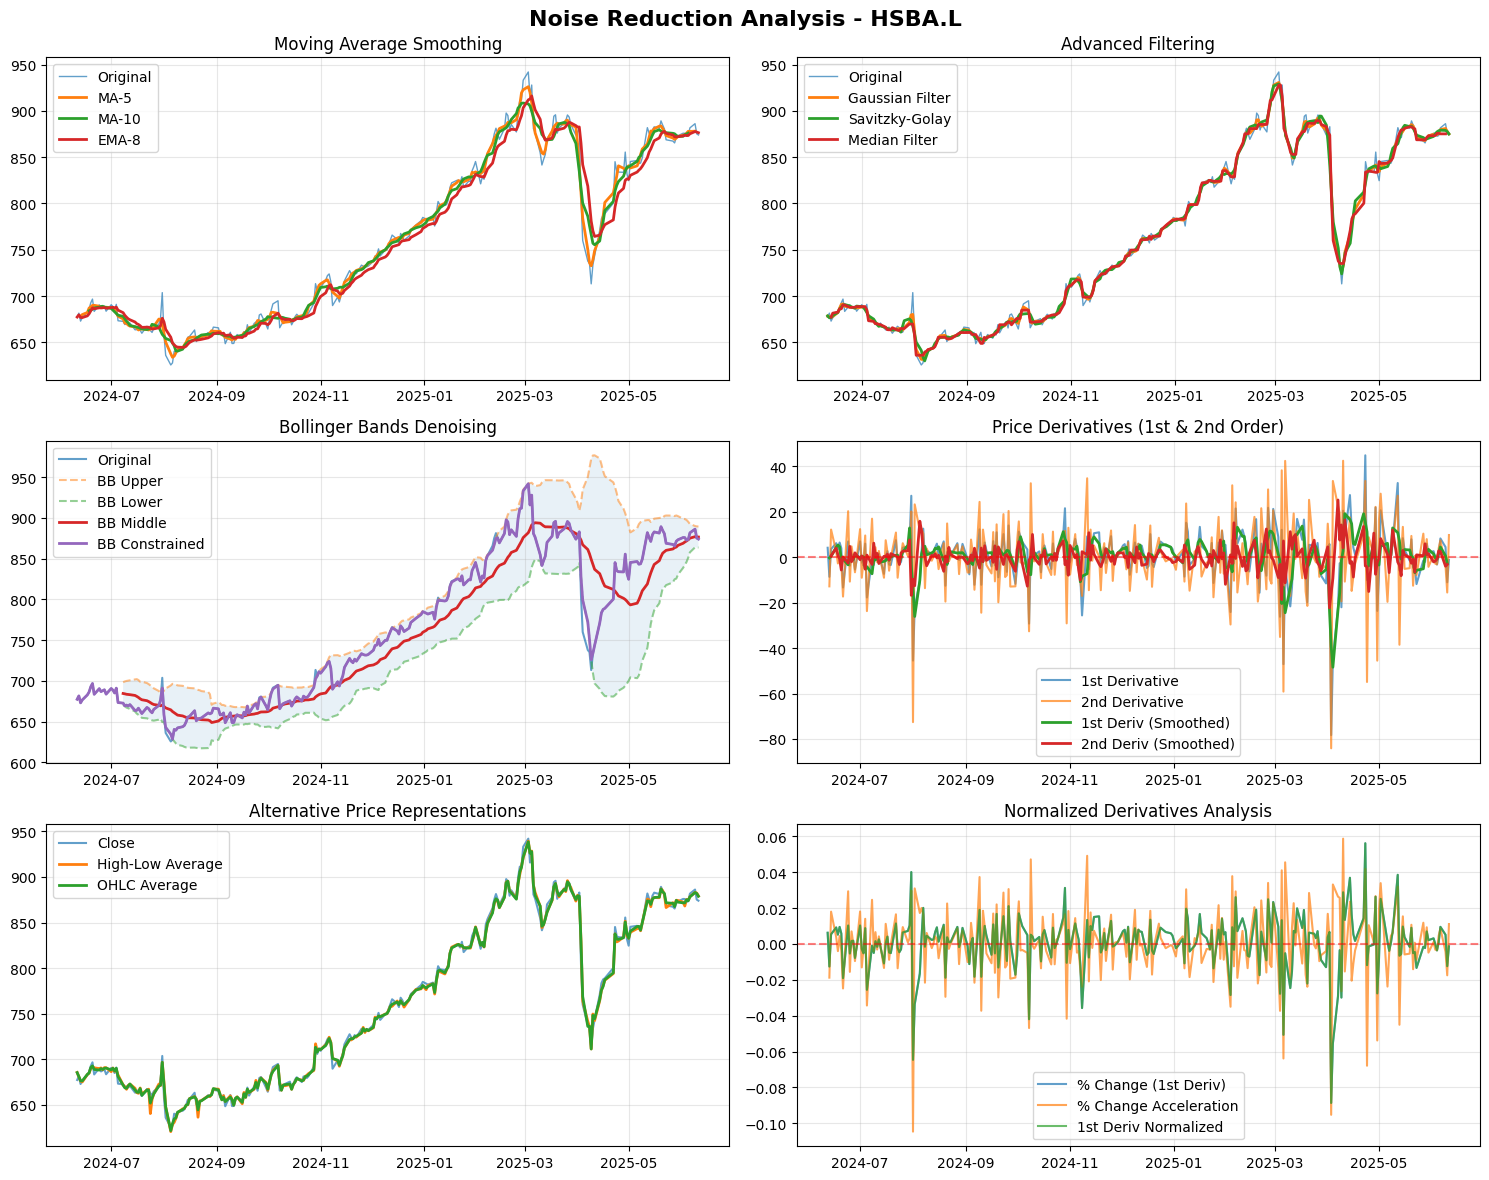

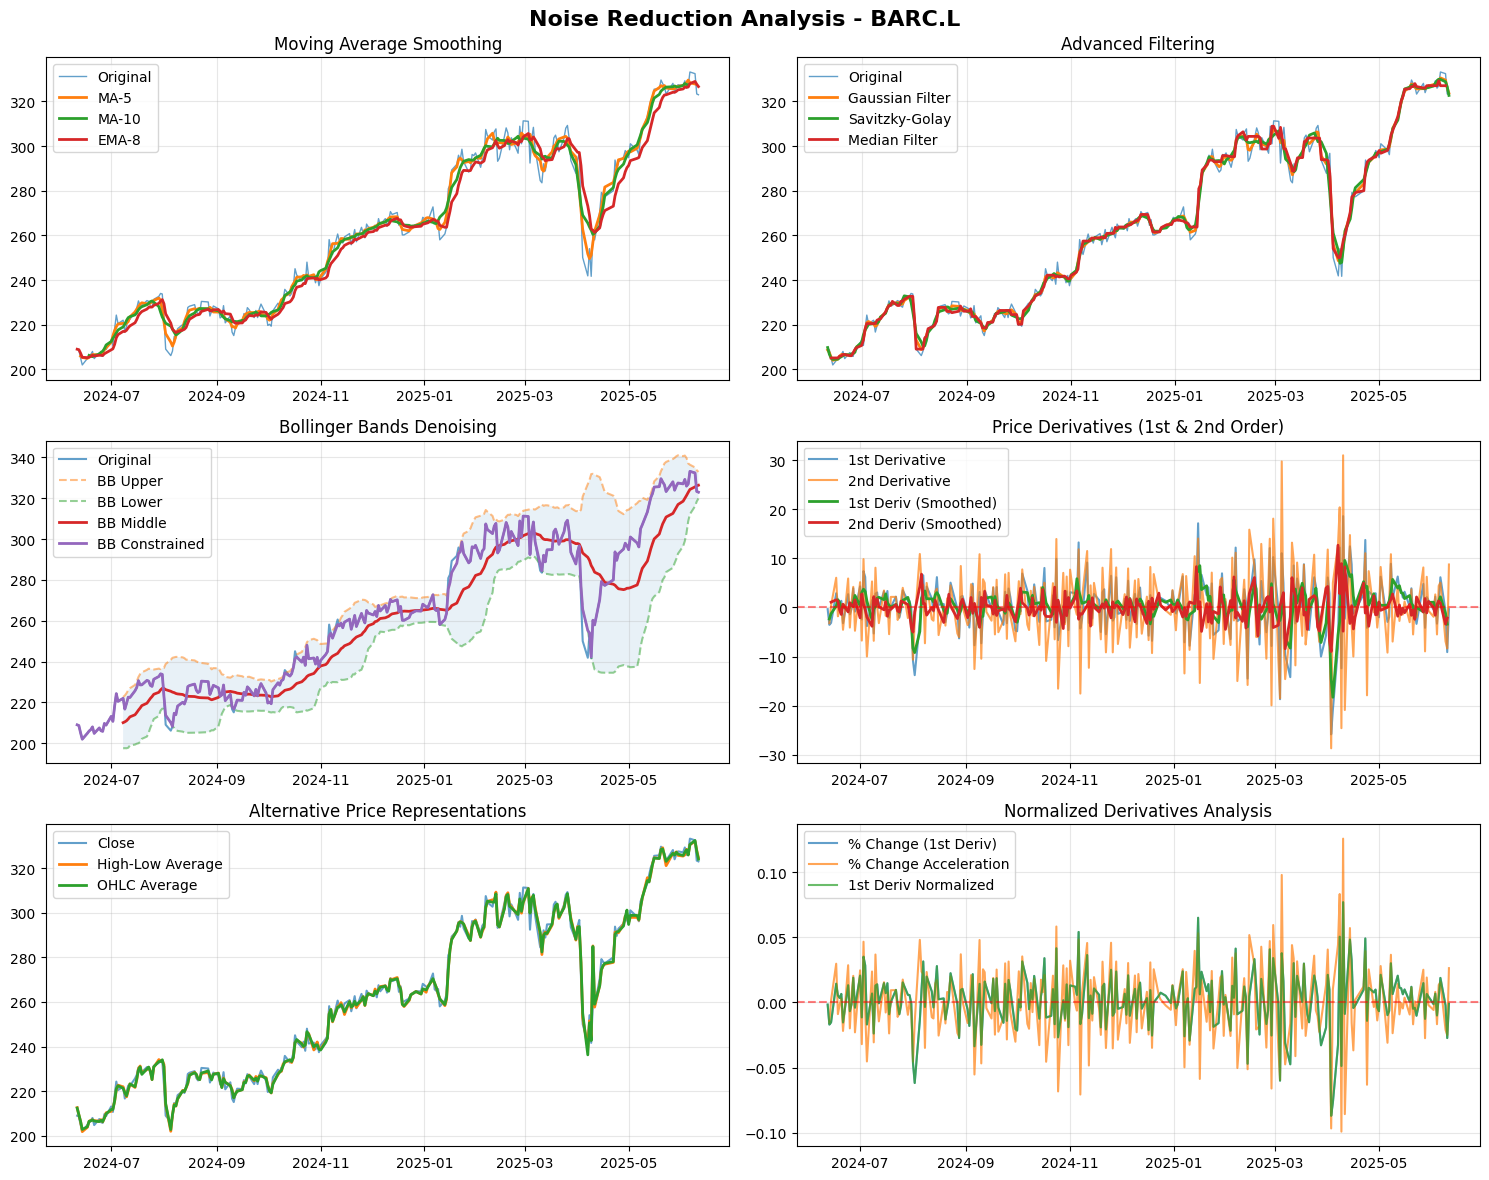

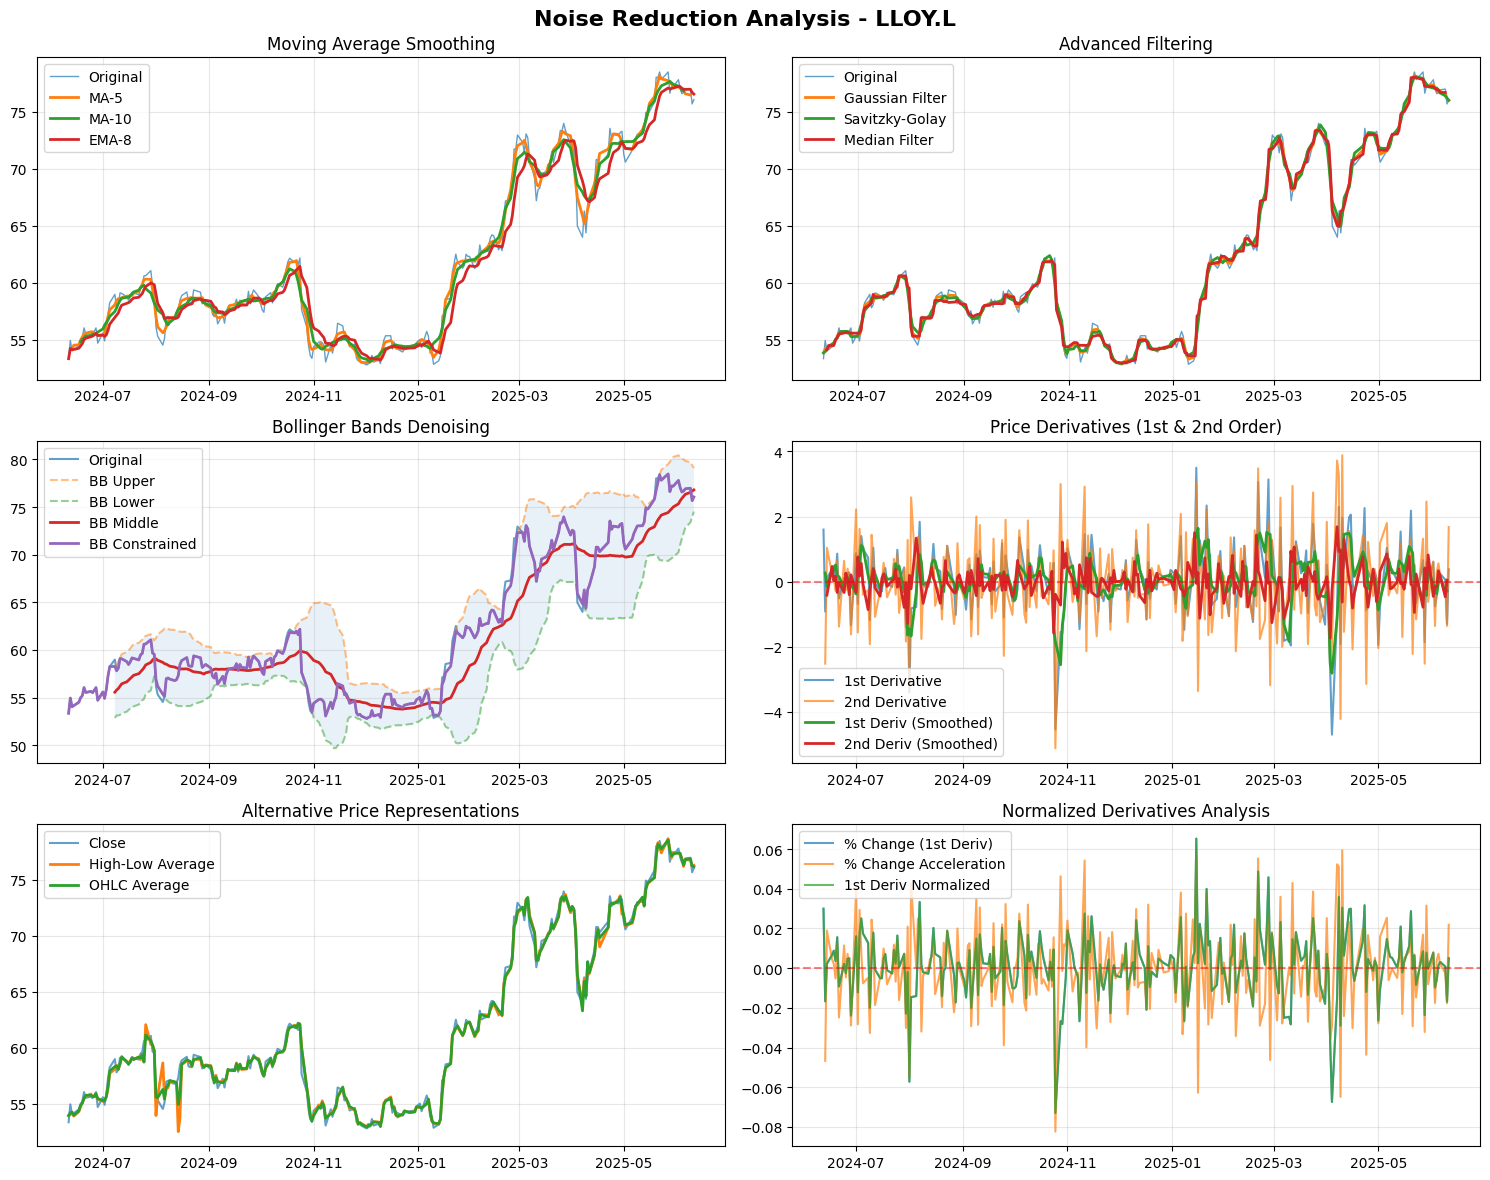

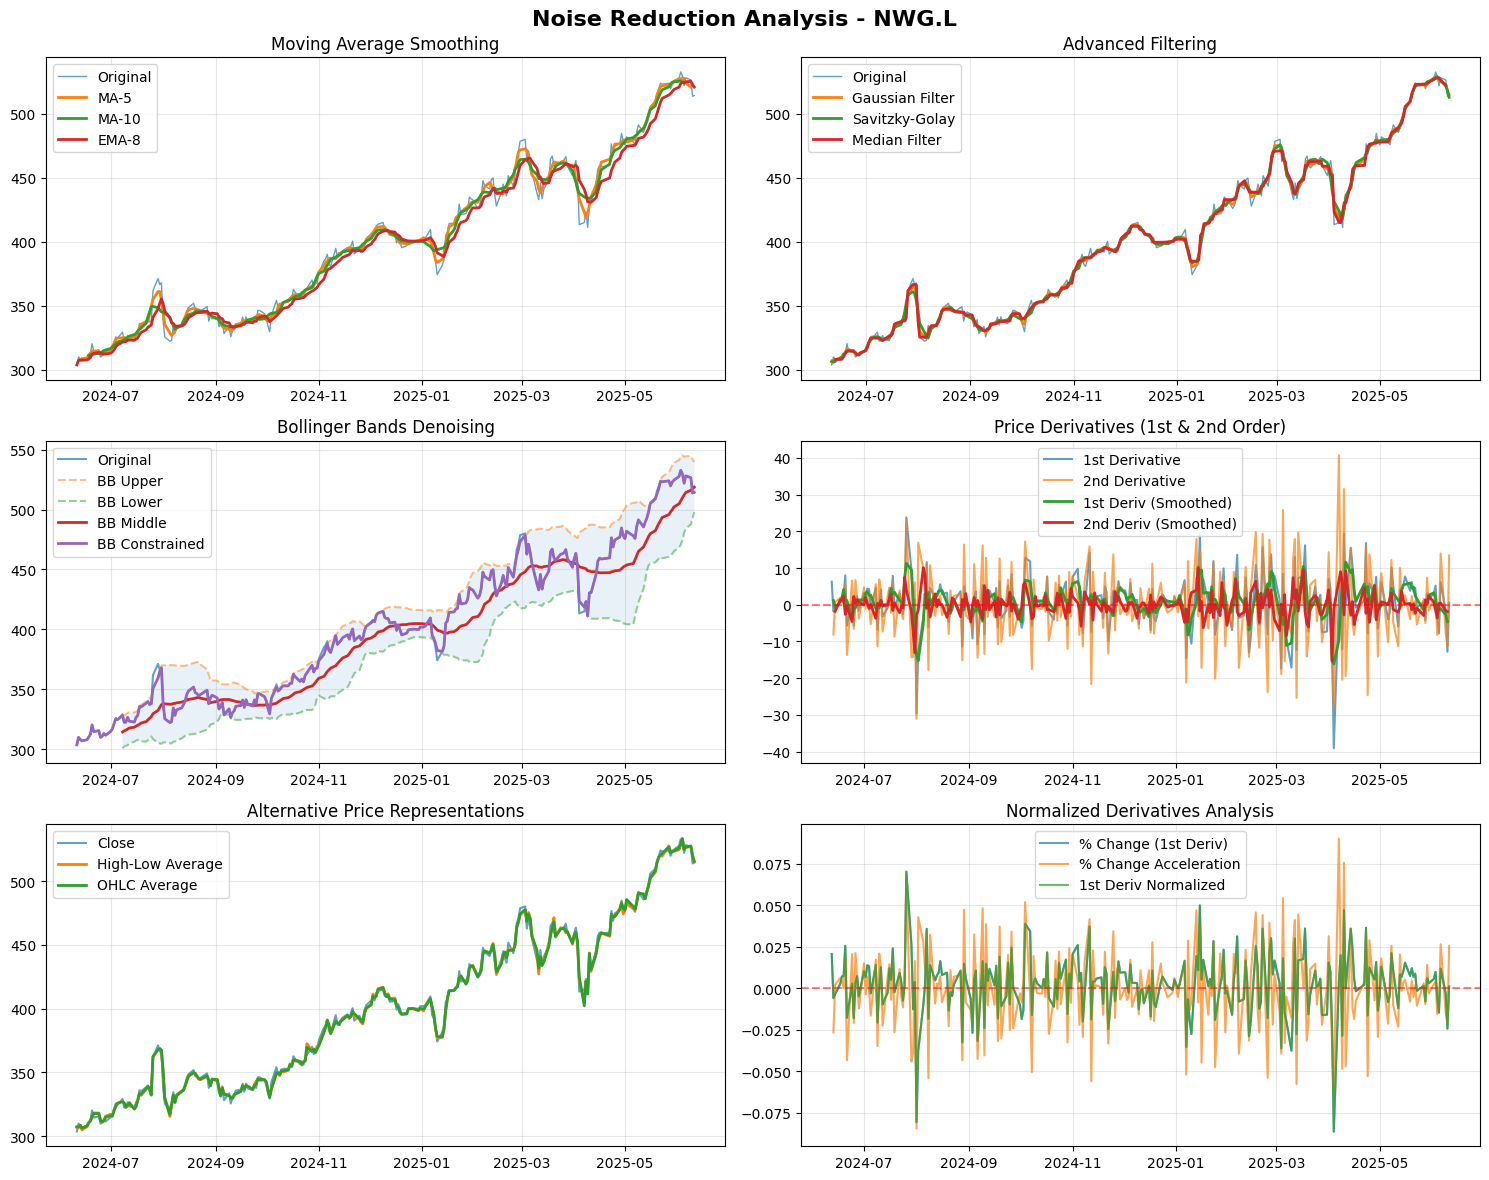

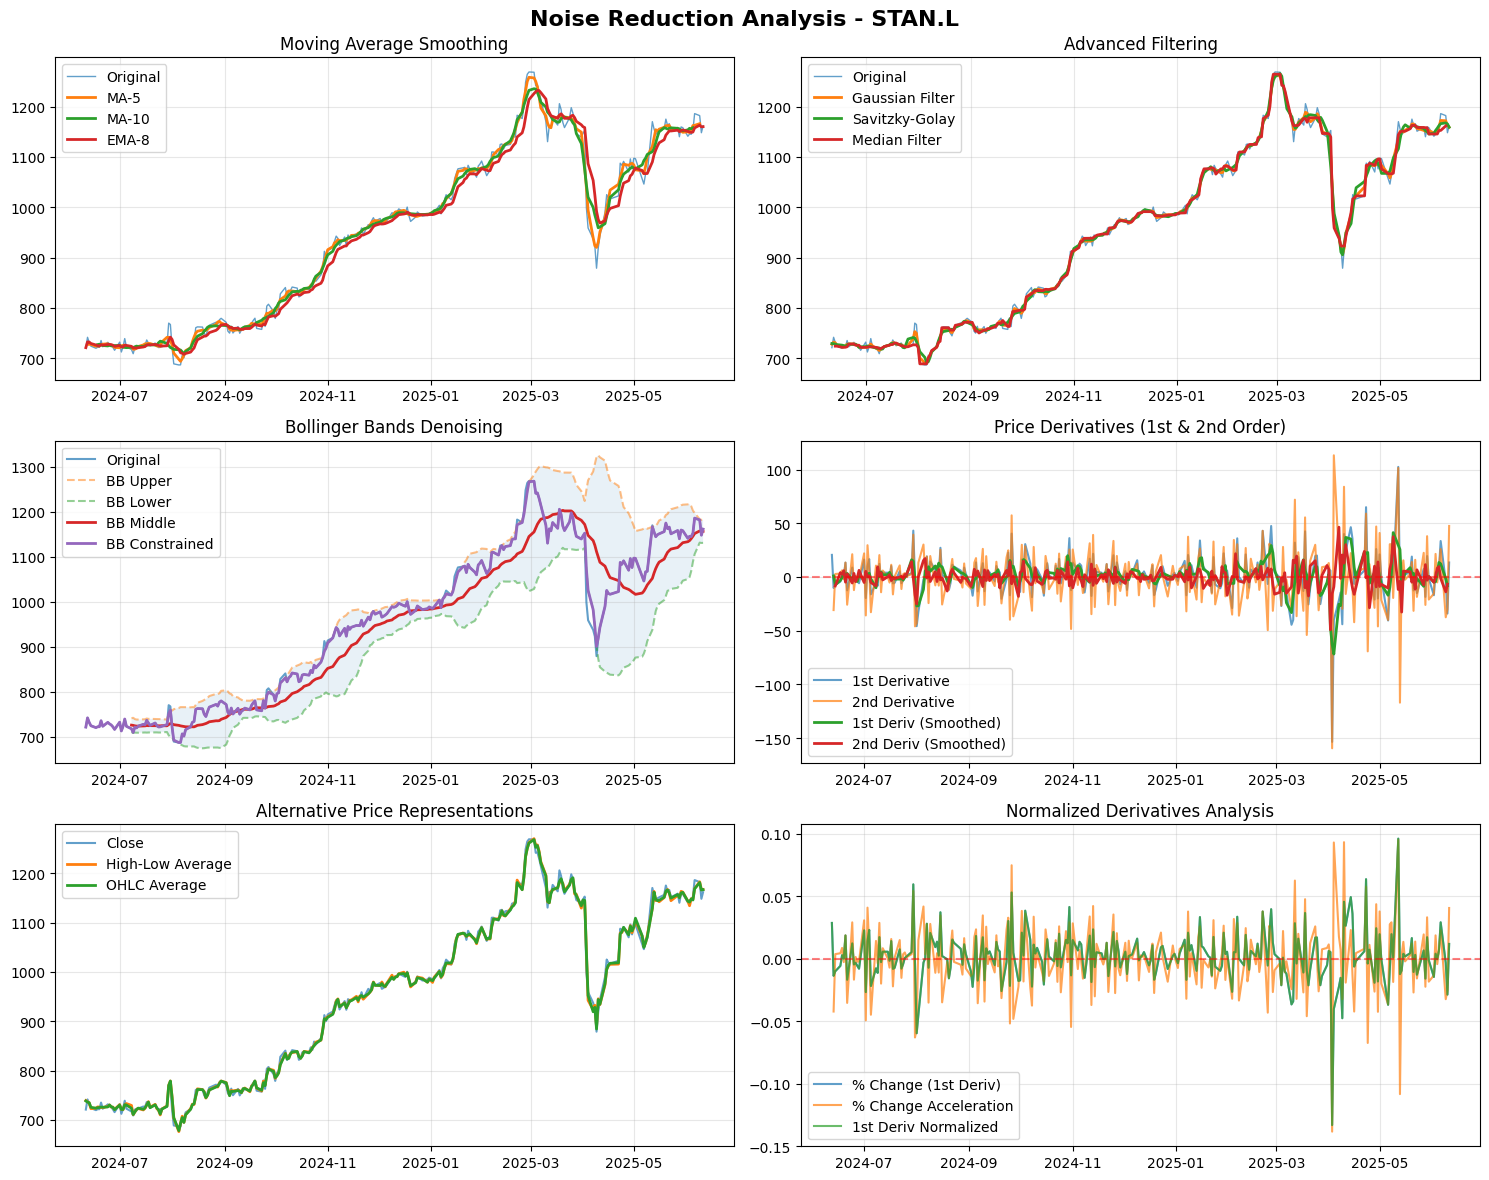

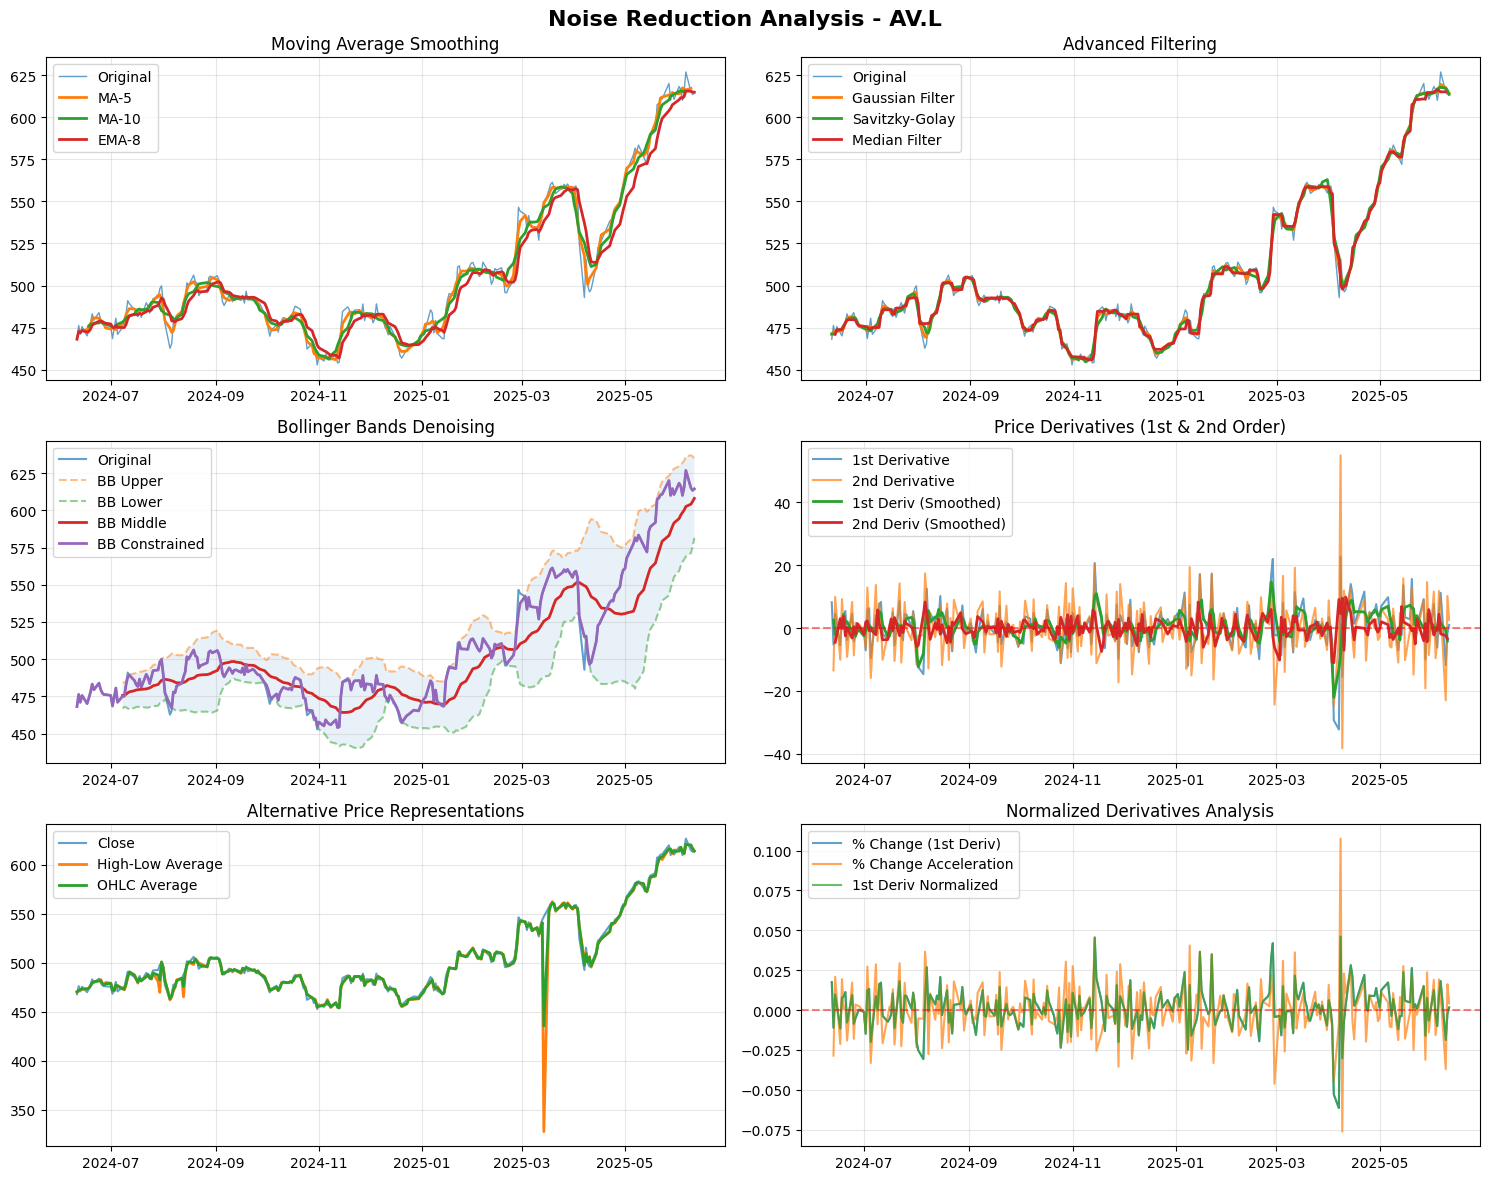

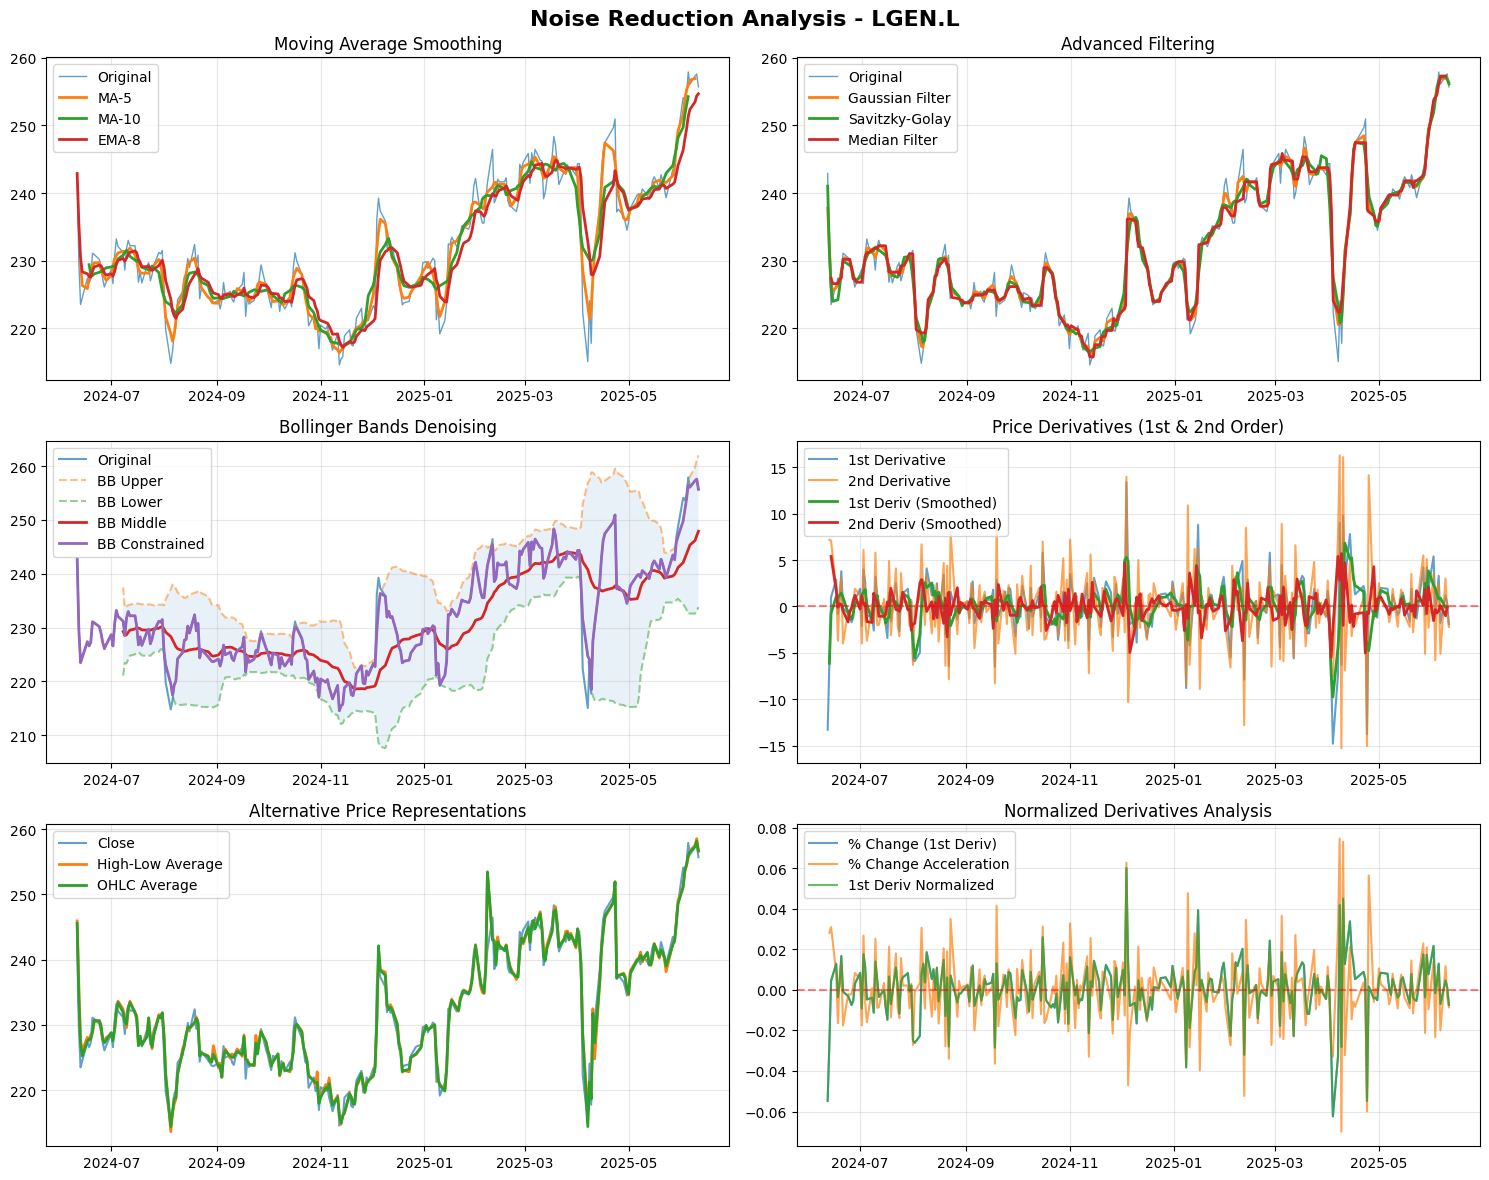

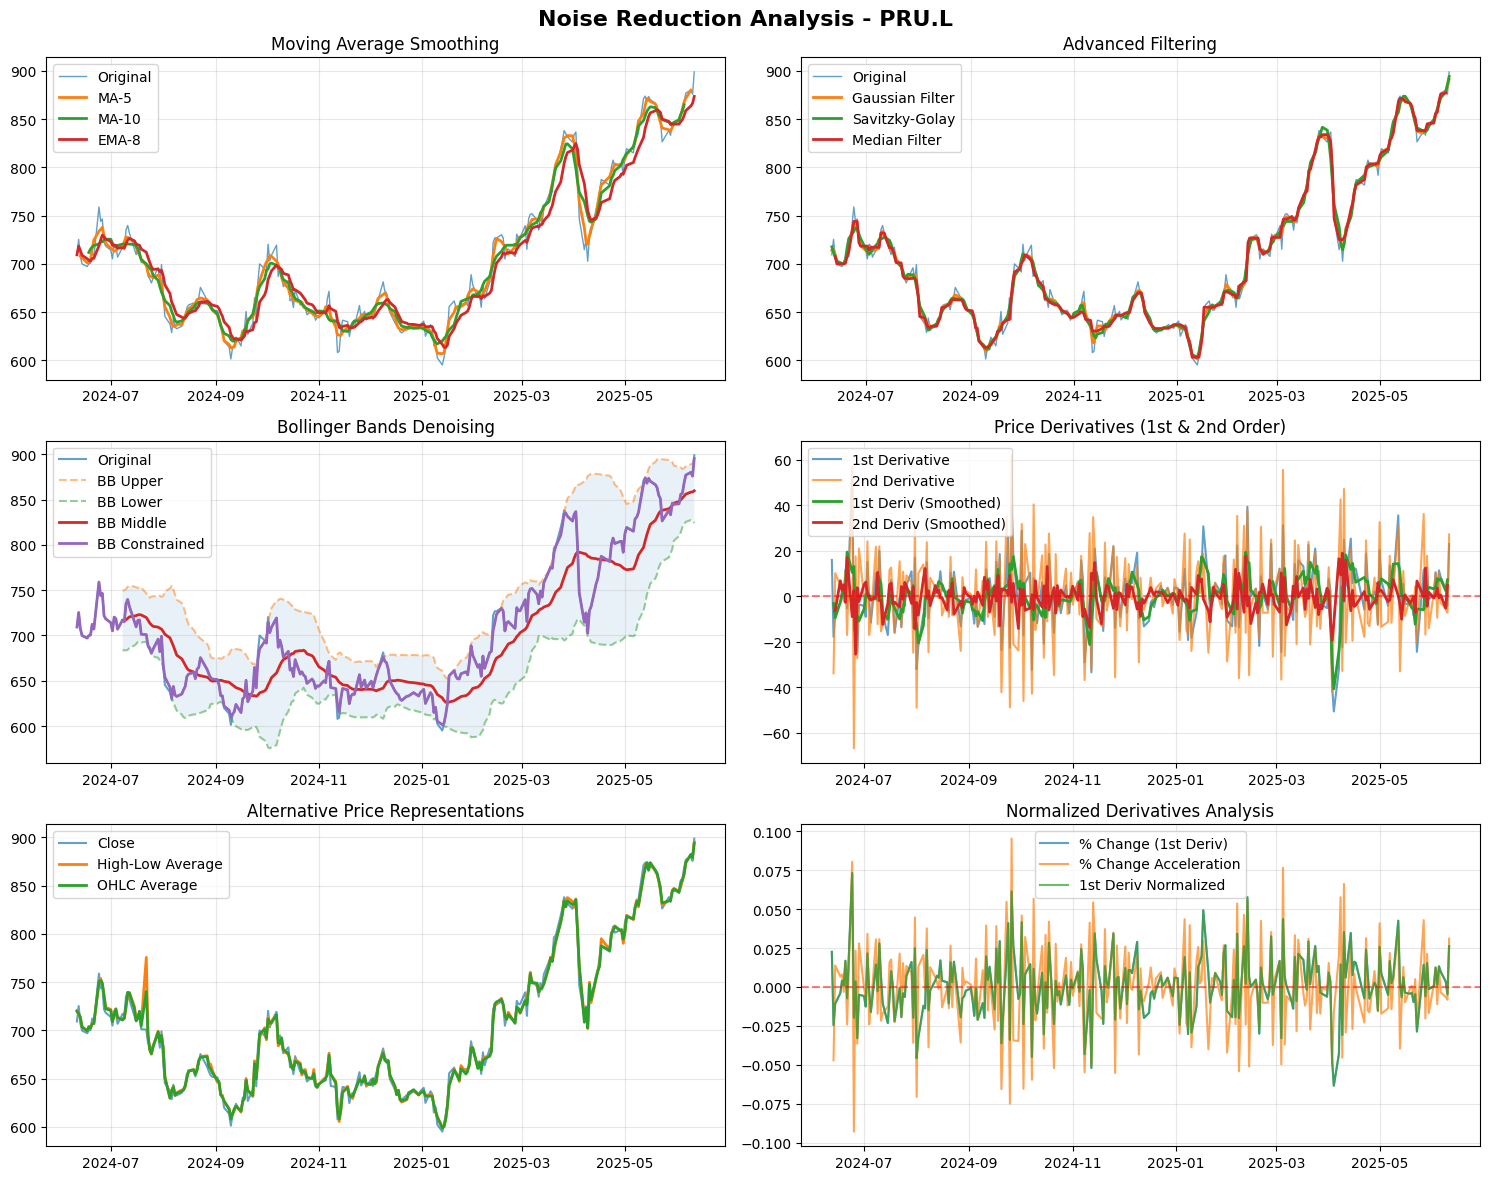

In [16]:
# Usage Example
def main():
    # Initialize the noise reducer
    reducer = StockNoiseReducer()
    
    # Fetch data (you can modify period and interval)
    reducer.fetch_data(period='1y', interval='1d')  # 3 months of daily data
    
    # Apply noise reduction techniques
    reducer.apply_noise_reduction()
    
    # Generate comprehensive analysis
    reducer.generate_summary_report()
    
    # Create visualizations for the first stock
    if reducer.processed_data:
        for symbol in reducer.processed_data.keys():
            reducer.visualize_comparison(symbol=symbol, save_plots=True)
        # first_symbol = list(reducer.processed_data.keys())[0]
        # reducer.visualize_comparison(symbol=first_symbol, save_plots=True)
        
        # first_symbol = list(reducer.processed_data.keys())[1]
        # reducer.visualize_comparison(symbol=first_symbol, save_plots=True)

if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import yfinance as yf
from scipy.ndimage import gaussian_filter1d
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class StockTimeSeriesPredictor:
    def __init__(self, symbols=None):
        
        if symbols is None:
            self.symbols = [
                'HSBA.L',   # HSBC Holdings
                'BARC.L',   # Barclays
                'LLOY.L',   # Lloyds Banking Group
                'NWG.L',    # NatWest Group
            ]
        else:
            self.symbols = symbols
        
        self.data = {}
        self.processed_data = {}
        self.models = {}
        self.results = {}
        self.scalers = {}
        self.history = {}
        
    def fetch_data(self, period='2y', interval='1d'):
        print("Fetching stock data...")
        for symbol in self.symbols:
            try:
                ticker = yf.Ticker(symbol)
                df = ticker.history(period=period, interval=interval)
                if not df.empty:
                    self.data[symbol] = df
                    print(f"✓ Downloaded {symbol}: {len(df)} records")
                else:
                    print(f"✗ No data for {symbol}")
            except Exception as e:
                print(f"✗ Error downloading {symbol}: {str(e)}")
    
    def apply_noise_reduction(self):
        
        print("\nApplying noise reduction techniques...")
        
        for symbol in self.data.keys():
            df = self.data[symbol].copy()
            processed = pd.DataFrame(index=df.index)
            
            # Original data
            processed['Close_Original'] = df['Close']
            processed['Volume'] = df['Volume']
            processed['High'] = df['High']
            processed['Low'] = df['Low']
            processed['Open'] = df['Open']
            
            # Technical indicators
            processed['Returns'] = df['Close'].pct_change()
            processed['Volatility'] = processed['Returns'].rolling(window=10).std()
            processed['Price_Range'] = (df['High'] - df['Low']) / df['Close']
            processed['RSI'] = self.calculate_rsi(df['Close'])
            processed['MACD'] = self.calculate_macd(df['Close'])
            
            # Smoothed versions
            processed['Close_MA5'] = df['Close'].rolling(window=5).mean()
            processed['Close_MA10'] = df['Close'].rolling(window=10).mean()
            processed['Close_MA20'] = df['Close'].rolling(window=20).mean()
            processed['Close_EMA8'] = df['Close'].ewm(span=8).mean()
            processed['Close_EMA21'] = df['Close'].ewm(span=21).mean()
            
            # Advanced filters
            processed['Close_Gaussian'] = pd.Series(
                gaussian_filter1d(df['Close'].values, sigma=1.0),
                index=df.index
            )
            
            if len(df) > 21:
                processed['Close_SavGol'] = pd.Series(
                    signal.savgol_filter(df['Close'].values, window_length=21, polyorder=3),
                    index=df.index
                )
            
            processed['Close_Median5'] = df['Close'].rolling(window=5).median()
            
            # Bollinger Bands
            bb_period = 20
            bb_std = 2
            sma = df['Close'].rolling(window=bb_period).mean()
            std = df['Close'].rolling(window=bb_period).std()
            processed['BB_Upper'] = sma + (std * bb_std)
            processed['BB_Lower'] = sma - (std * bb_std)
            processed['BB_Middle'] = sma
            processed['Close_BB_Constrained'] = df['Close'].clip(
                lower=processed['BB_Lower'], 
                upper=processed['BB_Upper']
            )
            
            # OHLC Average
            processed['Close_OHLC_Avg'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4
            
            # Price derivatives
            processed['Close_FirstDeriv'] = df['Close'].diff()
            processed['Close_SecondDeriv'] = df['Close'].diff().diff()
            processed['Close_FirstDeriv_Smooth'] = processed['Close_FirstDeriv'].rolling(window=3).mean()
            
            self.processed_data[symbol] = processed.dropna()
            print(f"✓ Processed {symbol}: {len(processed.dropna())} records")
    
    def calculate_rsi(self, prices, window=14):
        """Calculate RSI indicator"""
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    def calculate_macd(self, prices, fast=12, slow=26):
        """Calculate MACD indicator"""
        ema_fast = prices.ewm(span=fast).mean()
        ema_slow = prices.ewm(span=slow).mean()
        macd = ema_fast - ema_slow
        return macd
    
    def create_sequences(self, data, target_col, sequence_length=60, prediction_horizon=1):
        
        # Select features for the model
        feature_cols = [
            target_col, 'Volume', 'High', 'Low', 'Open', 'Returns', 
            'Volatility', 'Price_Range', 'RSI', 'MACD'
        ]
        
        # Filter available columns
        available_cols = [col for col in feature_cols if col in data.columns and not data[col].isna().all()]
        
        if not available_cols:
            return None, None
        
        # Create feature matrix
        feature_data = data[available_cols].values
        
        X, y = [], []
        for i in range(sequence_length, len(feature_data) - prediction_horizon + 1):
            X.append(feature_data[i-sequence_length:i])
            y.append(feature_data[i + prediction_horizon - 1, 0])  # Predict target_col (first column)
        
        return np.array(X), np.array(y)
    
    def create_models(self, input_shape):
       
        models = {}
        
        # 1. Simple LSTM
        model_lstm = Sequential([
            LSTM(50, return_sequences=True, input_shape=input_shape),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(25),
            Dense(1)
        ])
        model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
        models['LSTM'] = model_lstm
        
        # 2. Bidirectional LSTM
        model_bilstm = Sequential([
            Bidirectional(LSTM(50, return_sequences=True), input_shape=input_shape),
            Dropout(0.2),
            Bidirectional(LSTM(50, return_sequences=False)),
            Dropout(0.2),
            Dense(25),
            Dense(1)
        ])
        model_bilstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
        models['Bidirectional_LSTM'] = model_bilstm
        
        # 3. Deep LSTM
        model_deep_lstm = Sequential([
            LSTM(100, return_sequences=True, input_shape=input_shape),
            Dropout(0.2),
            LSTM(100, return_sequences=True),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(50),
            Dense(25),
            Dense(1)
        ])
        model_deep_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
        models['Deep_LSTM'] = model_deep_lstm
        
        # 4. CNN-LSTM
        model_cnn_lstm = Sequential([
            Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
            Conv1D(filters=64, kernel_size=3, activation='relu'),
            MaxPooling1D(pool_size=2),
            Dropout(0.2),
            LSTM(50, return_sequences=True),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dense(25),
            Dense(1)
        ])
        model_cnn_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
        models['CNN_LSTM'] = model_cnn_lstm
        
        # 5. GRU (Alternative to LSTM)
        model_gru = Sequential([
            GRU(50, return_sequences=True, input_shape=input_shape),
            Dropout(0.2),
            GRU(50, return_sequences=False),
            Dropout(0.2),
            Dense(25),
            Dense(1)
        ])
        model_gru.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
        models['GRU'] = model_gru
        
        # 6. Attention-like mechanism with LSTM
        model_attention_lstm = Sequential([
            LSTM(100, return_sequences=True, input_shape=input_shape),
            Dropout(0.2),
            LSTM(100, return_sequences=True),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(50, activation='tanh'),
            Dense(25),
            Dense(1)
        ])
        model_attention_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
        models['Attention_LSTM'] = model_attention_lstm
        
        return models
    
    def train_and_evaluate(self, symbol, target_columns, sequence_length=60, test_size=0.2, 
                          prediction_horizon=1, epochs=50, batch_size=32):
        
        print(f"\n🚀 Training deep learning models for {symbol}...")
        
        data = self.processed_data[symbol]
        symbol_results = {}
        
        for target_col in target_columns:
            if target_col not in data.columns:
                continue
                
            print(f"\n  📊 Training on {target_col}")
            
            # Create sequences
            X, y = self.create_sequences(data, target_col, sequence_length, prediction_horizon)
            
            if X is None or len(X) == 0:
                print(f"    ⚠️ No sequences created for {target_col}")
                continue
            
            # Train-test split (time series aware)
            split_idx = int(len(X) * (1 - test_size))
            X_train, X_test = X[:split_idx], X[split_idx:]
            y_train, y_test = y[:split_idx], y[split_idx:]
            
            # Normalize features
            scaler_key = f"{symbol}_{target_col}"
            self.scalers[scaler_key] = StandardScaler()
            
            # Reshape for scaling
            X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
            X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
            
            # Fit scaler and transform
            X_train_scaled = self.scalers[scaler_key].fit_transform(X_train_reshaped)
            X_test_scaled = self.scalers[scaler_key].transform(X_test_reshaped)
            
            # Reshape back
            X_train_scaled = X_train_scaled.reshape(X_train.shape)
            X_test_scaled = X_test_scaled.reshape(X_test.shape)
            
            # Create models
            models = self.create_models((X_train.shape[1], X_train.shape[2]))
            
            target_results = {}
            
            # Train each model
            for model_name, model in models.items():
                print(f"    🔄 Training {model_name}...")
                
                try:
                    # Callbacks
                    early_stopping = EarlyStopping(
                        monitor='val_loss', patience=10, restore_best_weights=True
                    )
                    reduce_lr = ReduceLROnPlateau(
                        monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001
                    )
                    
                    # Train model
                    history = model.fit(
                        X_train_scaled, y_train,
                        validation_split=0.2,
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping, reduce_lr],
                        verbose=0
                    )
                    
                    # Predictions
                    y_pred_train = model.predict(X_train_scaled, verbose=0).flatten()
                    y_pred_test = model.predict(X_test_scaled, verbose=0).flatten()
                    
                    # Metrics
                    metrics = {
                        'train_mse': mean_squared_error(y_train, y_pred_train),
                        'test_mse': mean_squared_error(y_test, y_pred_test),
                        'train_mae': mean_absolute_error(y_train, y_pred_train),
                        'test_mae': mean_absolute_error(y_test, y_pred_test),
                        'train_r2': r2_score(y_train, y_pred_train),
                        'test_r2': r2_score(y_test, y_pred_test),
                        'y_test': y_test,
                        'y_pred_test': y_pred_test,
                        'test_indices': data.index[split_idx + sequence_length:split_idx + sequence_length + len(y_test)],
                        'history': history.history
                    }
                    
                    target_results[model_name] = metrics
                    
                    print(f"    ✓ {model_name}: Test R² = {metrics['test_r2']:.4f}, Test MAE = {metrics['test_mae']:.4f}")
                    
                except Exception as e:
                    print(f"    ✗ {model_name}: {str(e)}")
            
            symbol_results[target_col] = target_results
        
        self.results[symbol] = symbol_results
        return symbol_results
    
    def plot_training_history(self, symbol, target_col, models_to_plot=None):
       
        if models_to_plot is None:
            models_to_plot = ['LSTM', 'CNN_LSTM', 'Bidirectional_LSTM']
        
        symbol_results = self.results[symbol]
        if target_col not in symbol_results:
            return
        
        target_results = symbol_results[target_col]
        
        fig, axes = plt.subplots(2, len(models_to_plot), figsize=(5*len(models_to_plot), 8))
        fig.suptitle(f'Training History - {symbol} - {target_col}', fontsize=16, fontweight='bold')
        
        if len(models_to_plot) == 1:
            axes = axes.reshape(-1, 1)
        
        for i, model_name in enumerate(models_to_plot):
            if model_name in target_results and 'history' in target_results[model_name]:
                history = target_results[model_name]['history']
                
                # Plot loss
                axes[0, i].plot(history['loss'], label='Training Loss')
                axes[0, i].plot(history['val_loss'], label='Validation Loss')
                axes[0, i].set_title(f'{model_name} - Loss')
                axes[0, i].set_xlabel('Epoch')
                axes[0, i].set_ylabel('Loss')
                axes[0, i].legend()
                axes[0, i].grid(True, alpha=0.3)
                
                # Plot MAE
                axes[1, i].plot(history['mae'], label='Training MAE')
                axes[1, i].plot(history['val_mae'], label='Validation MAE')
                axes[1, i].set_title(f'{model_name} - MAE')
                axes[1, i].set_xlabel('Epoch')
                axes[1, i].set_ylabel('MAE')
                axes[1, i].legend()
                axes[1, i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_predictions(self, symbol, target_columns, models_to_plot=None):
        """
        Plot predictions vs actual values for comparison
        """
        if models_to_plot is None:
            models_to_plot = ['LSTM', 'CNN_LSTM', 'Bidirectional_LSTM', 'GRU']
        
        symbol_results = self.results[symbol]
        
        n_targets = len(target_columns)
        n_models = len(models_to_plot)
        
        fig, axes = plt.subplots(n_targets, n_models, figsize=(5*n_models, 4*n_targets))
        fig.suptitle(f'Time Series Predictions - {symbol}', fontsize=16, fontweight='bold')
        
        if n_targets == 1:
            axes = axes.reshape(1, -1)
        if n_models == 1:
            axes = axes.reshape(-1, 1)
        
        for i, target_col in enumerate(target_columns):
            if target_col not in symbol_results:
                continue
                
            target_results = symbol_results[target_col]
            
            for j, model_name in enumerate(models_to_plot):
                ax = axes[i, j]
                
                if model_name in target_results:
                    results = target_results[model_name]
                    
                    # Plot actual vs predicted
                    test_indices = results['test_indices']
                    y_test = results['y_test']
                    y_pred = results['y_pred_test']
                    
                    ax.plot(test_indices, y_test, label='Actual', alpha=0.8, linewidth=2)
                    ax.plot(test_indices, y_pred, label='Predicted', alpha=0.8, linewidth=2)
                    
                    # Add performance metrics to plot
                    r2 = results['test_r2']
                    mae = results['test_mae']
                    ax.text(0.02, 0.98, f'R²: {r2:.3f}\nMAE: {mae:.3f}', 
                           transform=ax.transAxes, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                    
                    ax.set_title(f'{model_name}\n{target_col}')
                    ax.legend()
                    ax.grid(True, alpha=0.3)
                    
                    # Rotate x-axis labels for better readability
                    ax.tick_params(axis='x', rotation=45)
                else:
                    ax.text(0.5, 0.5, 'No Results', ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(f'{model_name}\n{target_col}')
        
        plt.tight_layout()
        plt.show()
    
    def generate_performance_summary(self):
        """
        Generate comprehensive performance comparison
        """
        print("\n" + "="*100)
        print("DEEP LEARNING TIME SERIES PREDICTION PERFORMANCE")
        print("="*100)
        
        summary_data = []
        
        for symbol in self.results.keys():
            symbol_results = self.results[symbol]
            
            print(f"\n📈 {symbol} Results:")
            print("-" * 80)
            
            for target_col in symbol_results.keys():
                print(f"\n🎯 Target: {target_col}")
                print("-" * 50)
                
                target_results = symbol_results[target_col]
                
                # Sort models by test R² score
                sorted_models = sorted(target_results.items(), 
                                     key=lambda x: x[1]['test_r2'], reverse=True)
                
                print(f"{'Model':<20} {'Test R²':<10} {'Test MAE':<12} {'Test MSE':<12}")
                print("-" * 56)
                
                for model_name, metrics in sorted_models:
                    print(f"{model_name:<20} {metrics['test_r2']:<10.4f} "
                          f"{metrics['test_mae']:<12.4f} {metrics['test_mse']:<12.4f}")
                    
                    # Store for summary table
                    summary_data.append({
                        'Symbol': symbol,
                        'Target': target_col,
                        'Model': model_name,
                        'Test_R2': metrics['test_r2'],
                        'Test_MAE': metrics['test_mae'],
                        'Test_MSE': metrics['test_mse']
                    })
        
        # Create summary DataFrame
        summary_df = pd.DataFrame(summary_data)
        
        print(f"\n" + "="*100)
        print("OVERALL DEEP LEARNING SUMMARY")
        print("="*100)
        
        # Best model per target type
        print("\n🏆 Best Deep Learning Models by Target Type:")
        print("-" * 60)
        
        for target in summary_df['Target'].unique():
            target_data = summary_df[summary_df['Target'] == target]
            best_model = target_data.loc[target_data['Test_R2'].idxmax()]
            print(f"{target:<25}: {best_model['Model']} (R²={best_model['Test_R2']:.4f})")
        
        # Model ranking across all targets
        print("\n📊 Average Deep Learning Model Performance:")
        print("-" * 60)
        model_avg = summary_df.groupby('Model').agg({
            'Test_R2': 'mean',
            'Test_MAE': 'mean',
            'Test_MSE': 'mean'
        }).round(4)
        
        model_avg = model_avg.sort_values('Test_R2', ascending=False)
        print(model_avg)
        
        # Impact of noise reduction on deep learning models
        print(f"\n🔍 Noise Reduction Impact on Deep Learning:")
        print("-" * 60)
        
        original_performance = summary_df[summary_df['Target'] == 'Close_Original']['Test_R2'].mean()
        
        smoothed_targets = [col for col in summary_df['Target'].unique() 
                          if col != 'Close_Original' and 'Close_' in col]
        
        for target in smoothed_targets:
            target_performance = summary_df[summary_df['Target'] == target]['Test_R2'].mean()
            improvement = target_performance - original_performance
            print(f"{target:<25}: Avg R² = {target_performance:.4f} "
                  f"({improvement:+.4f} vs Original)")
        
        return summary_df
    
    def run_full_analysis(self, period='2y', sequence_length=60, test_size=0.2, 
                         prediction_horizon=1, epochs=50, batch_size=32):
        """
        Run complete deep learning time series analysis pipeline
        """
        # Data collection and processing
        self.fetch_data(period=period)
        self.apply_noise_reduction()
        
        # Define target columns to test
        target_columns = [
            'Close_Original',
            'Close_MA5',
            'Close_MA10',
            'Close_EMA8',
            'Close_Gaussian',
            'Close_SavGol',
            'Close_Median5',
            'Close_BB_Constrained',
            'Close_OHLC_Avg'
        ]
        
        # Train and evaluate for each symbol
        for symbol in self.processed_data.keys():
            # Filter available targets
            available_targets = [col for col in target_columns 
                               if col in self.processed_data[symbol].columns]
            
            if available_targets:
                self.train_and_evaluate(
                    symbol, available_targets, sequence_length, 
                    test_size, prediction_horizon, epochs, batch_size
                )
                
                # Plot training history for key targets
                key_targets = ['Close_Original', 'Close_MA5', 'Close_Gaussian']
                for target in key_targets:
                    if target in available_targets:
                        self.plot_training_history(symbol, target)
                
                # Plot predictions for key targets
                available_key_targets = [col for col in key_targets if col in available_targets]
                if available_key_targets:
                    self.plot_predictions(symbol, available_key_targets)
        
        # Generate summary
        summary_df = self.generate_performance_summary()
        
        return summary_df


Stocks Selection

In [157]:
import yfinance as yf
periods = '2y'#'6mo'  # 1 year of data
intervals = '1d'  # Daily data
symbols = [
                'HSBA.L',   # HSBC Holdings
                'BARC.L',   # Barclays
                'LLOY.L',   # Lloyds Banking Group
                'NWG.L',    # NatWest Group
                'STAN.L',   # Standard Chartered
                'AV.L',     # Aviva
                'LGEN.L',   # Legal & General
                'PRU.L'     # Prudential
            ]
ticker = yf.Ticker(symbols[0])
df = ticker.history(period=periods, interval=intervals)

Feature testing

In [164]:
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy import signal

processed = pd.DataFrame(index=df.index)
# Original price data
processed['Close_Original'] = df['Close']
processed['Volume_Original'] = df['Volume']
            
# 1. Log Transform
processed['Close_LogTransform'] = np.log(df['Close'])
processed['Volume_LogTransform'] = np.log(df['Volume'] + 1)  # Avoid log(0)
            
# 2. First and Second Order Derivatives (Price Changes and Acceleration)
processed['Close_FirstDerivative'] = df['Close'].diff()
processed['Close_PctChange'] = df['Close'].pct_change()
            
# Second Order Derivative (Acceleration/Momentum changes)
processed['Close_SecondDerivative'] = df['Close'].diff().diff()
processed['Close_PctChange_Acceleration'] = df['Close'].pct_change().diff()
            
# Smooth derivatives using different methods
# processed['Close_FirstDeriv_MA3'] = processed['Close_FirstDerivative'].rolling(window=3, center=True).mean()
# processed['Close_SecondDeriv_MA3'] = processed['Close_SecondDerivative'].rolling(window=3, center=True).mean()
            
# Normalized derivatives (useful for comparing across different price levels)
processed['Close_FirstDeriv_Normalized'] = processed['Close_FirstDerivative'] / df['Close'].shift(1)
processed['Close_SecondDeriv_Normalized'] = processed['Close_SecondDerivative'] / df['Close'].shift(2)
 
# 3. Moving Average Smoothing
processed['Close_EMA8'] = df['Close'].ewm(span=8).mean()
            
# 4. Gaussian Filter (Smooth noise reduction)
processed['Close_Gaussian'] = pd.Series(
    gaussian_filter1d(df['Close'].values, sigma=1.0),
    index=df.index
)
            
# 5. Savitzky-Golay Filter (Preserves peaks better)
if len(df) > 11:  # Need enough points for filter
    processed['Close_SavGol'] = pd.Series(
        signal.savgol_filter(df['Close'].values, window_length=11, polyorder=3),
            index=df.index
    )
            
# 6. Z-Score Normalization
processed['Close_ZScore'] = (df['Close'] - df['Close'].mean()) / df['Close'].std()
                

In [165]:
# 7. Bollinger Bands Denoising
bb_period = 10
bb_std = 2

sma = df['Close'].rolling(window=bb_period).mean()
std = df['Close'].rolling(window=bb_period).std()
processed['BB_Upper'] = sma + (std * bb_std)
processed['BB_Lower'] = sma - (std * bb_std)
processed['BB_Middle'] = sma
            
# Constrain price within Bollinger Bands as noise reduction
# processed['Close_BB_Constrained'] = df['Close'].clip(
#     lower=processed['BB_Lower'], 
#     upper=processed['BB_Upper']
# )
            
# 8. Median Filter (Remove outliers)
processed['Close_Median5'] = df['Close'].rolling(window=5, center=True).median()
            
# 9. High-Low Average (Reduces intraday noise)
processed['HL_Average'] = (df['High'] + df['Low']) / 2
processed['OHLC_Average'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4
            

In [169]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
Sacler1 = MinMaxScaler()
processed['Close_MinMax'] = Sacler1.fit_transform(processed[['Close_Original']])
processed['Volume_MinMax'] = Sacler1.fit_transform(processed[['Volume_Original']])
processed['Close_Gaussian_MinMax'] = Sacler1.fit_transform(processed[['Close_Gaussian']])
processed['BB_Upper_MinMax'] = Sacler1.fit_transform(processed[['BB_Upper']])
processed['BB_Lower_MinMax'] = Sacler1.fit_transform(processed[['BB_Lower']])
processed['Close_SavGol_MinMax'] = Sacler1.fit_transform(processed[['Close_SavGol']])
processed['Close_EMA8_MinMax'] = Sacler1.fit_transform(processed[['Close_EMA8']])

high_close_diff = (df['High'] - df['Close']).values.reshape(-1, 1)
processed['High_Dif_minmax'] = Sacler1.fit_transform(high_close_diff)
processed['High_minmax'] = Sacler1.fit_transform((df['High']).values.reshape(-1, 1))
low_close_diff = (df['Low'] - df['Close']).values.reshape(-1, 1)
processed['Low_Dif_minmax'] = Sacler1.fit_transform(low_close_diff)
processed['Low_minmax'] = Sacler1.fit_transform((df['Low']).values.reshape(-1, 1))
# processed['Low_minmax'] = Sacler1.fit_transform((df['Close'] -df['Low']).values.reshape(-1, 1))

Scaler2 = StandardScaler()#Volume_Original
processed['Volume_LogTransform_stanard'] = Scaler2.fit_transform(processed[['Volume_LogTransform']])

Feature selection

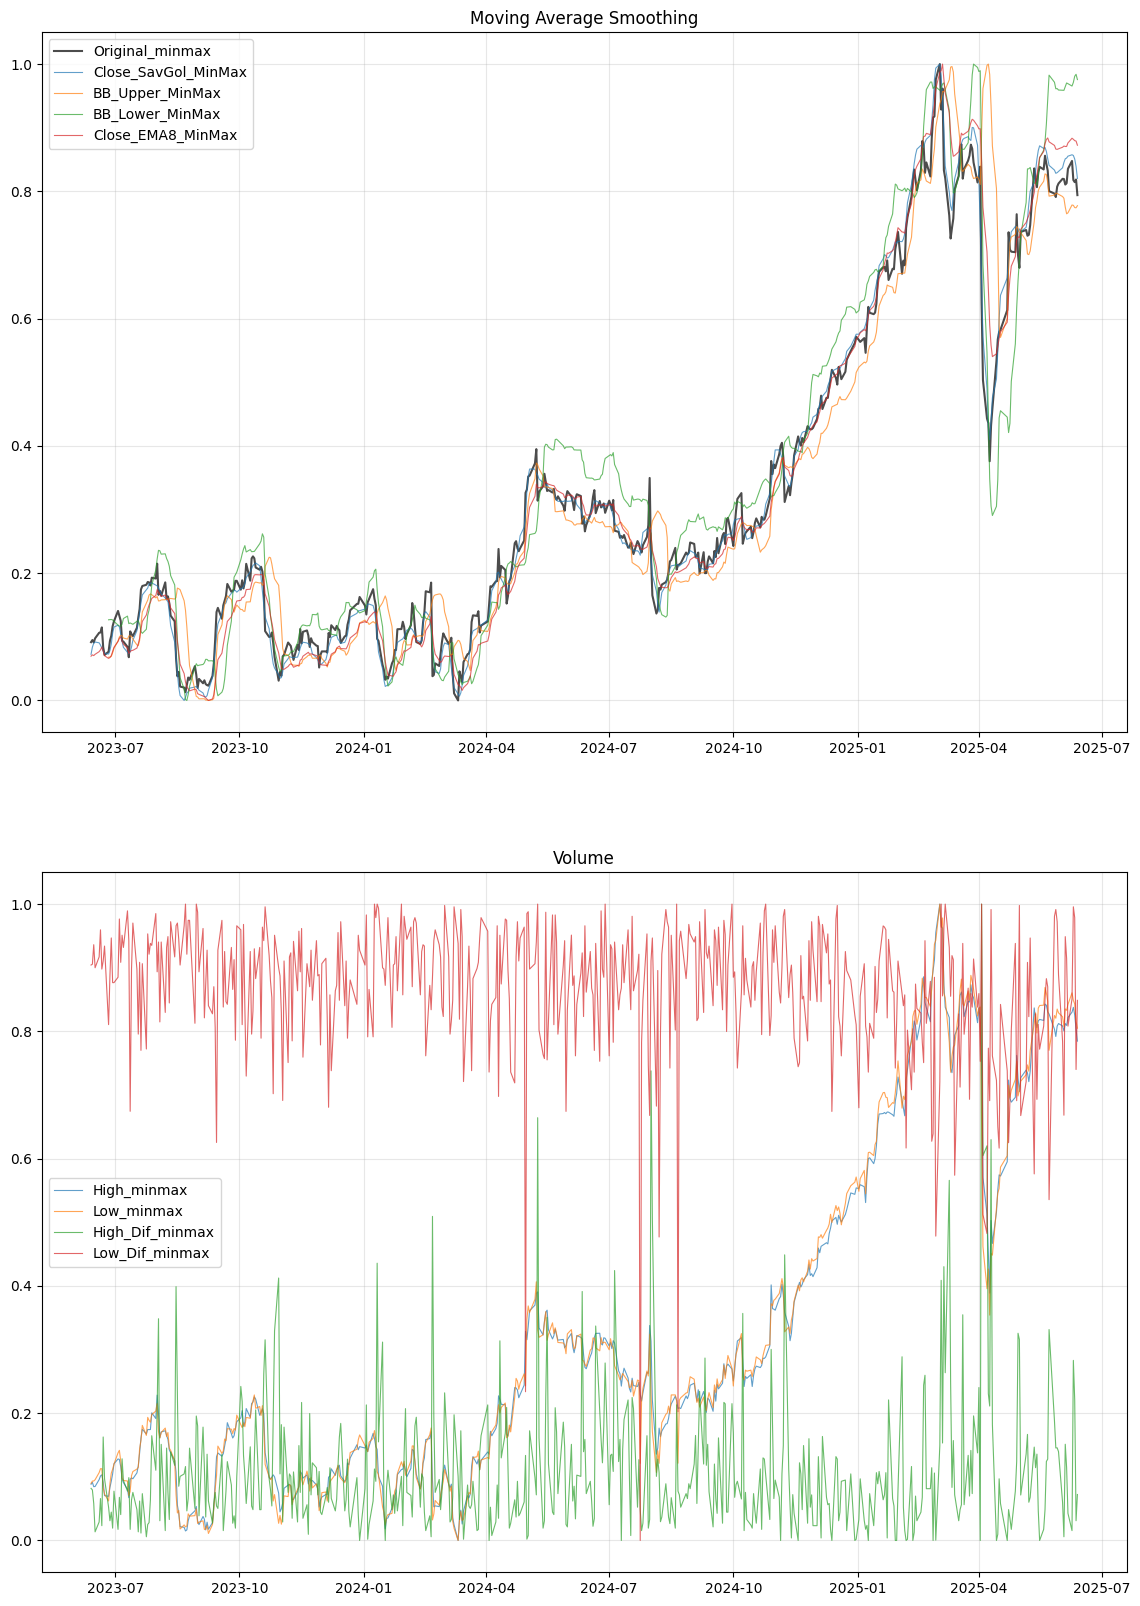

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 1, figsize=(14, 20))
indexs = [
    # 'Close_Original',
    #'Close_Gaussian', 'Close_SavGol', 
    # 'HL_Average', 'OHLC_Average',
    # 'BB_Upper', 'BB_Lower', 
    # 'BB_Middle'
    #'Close_EMA8',
    # 'Close_Gaussian_MinMax', 
    'Close_SavGol_MinMax',
    'BB_Upper_MinMax', 'BB_Lower_MinMax',
    'Close_EMA8_MinMax', 
]

# Plot 1: Original vs Moving Averages
axes[0].plot(processed.index, processed['Close_MinMax'], 
             label='Original_minmax', alpha=0.7, linewidth=1.5, color='black')
for index1 in indexs:
    if index1 in processed.columns:
        # if index1 != 'Close_Original':
            axes[0].plot(df.index, processed[index1], label=index1, alpha=0.7, linewidth=0.8)

axes[0].set_title('Moving Average Smoothing')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
#################

indexs = [
    #'Volume_LogTransform_stanard',
    'High_minmax', 'Low_minmax', 
    'High_Dif_minmax', 'Low_Dif_minmax',
]
# Plot 1: Original vs Moving Averages
# axes[1].plot(processed.index, processed['Volume_Original'], 
            #  label='Volume', alpha=0.7, linewidth=0.5, color='black')
for index1 in indexs:
    if index1 in processed.columns:
        axes[1].plot(df.index, processed[index1], label=index1, alpha=0.7, linewidth=0.8)

axes[1].set_title('Volume')
axes[1].legend()
axes[1].grid(True, alpha=0.3)


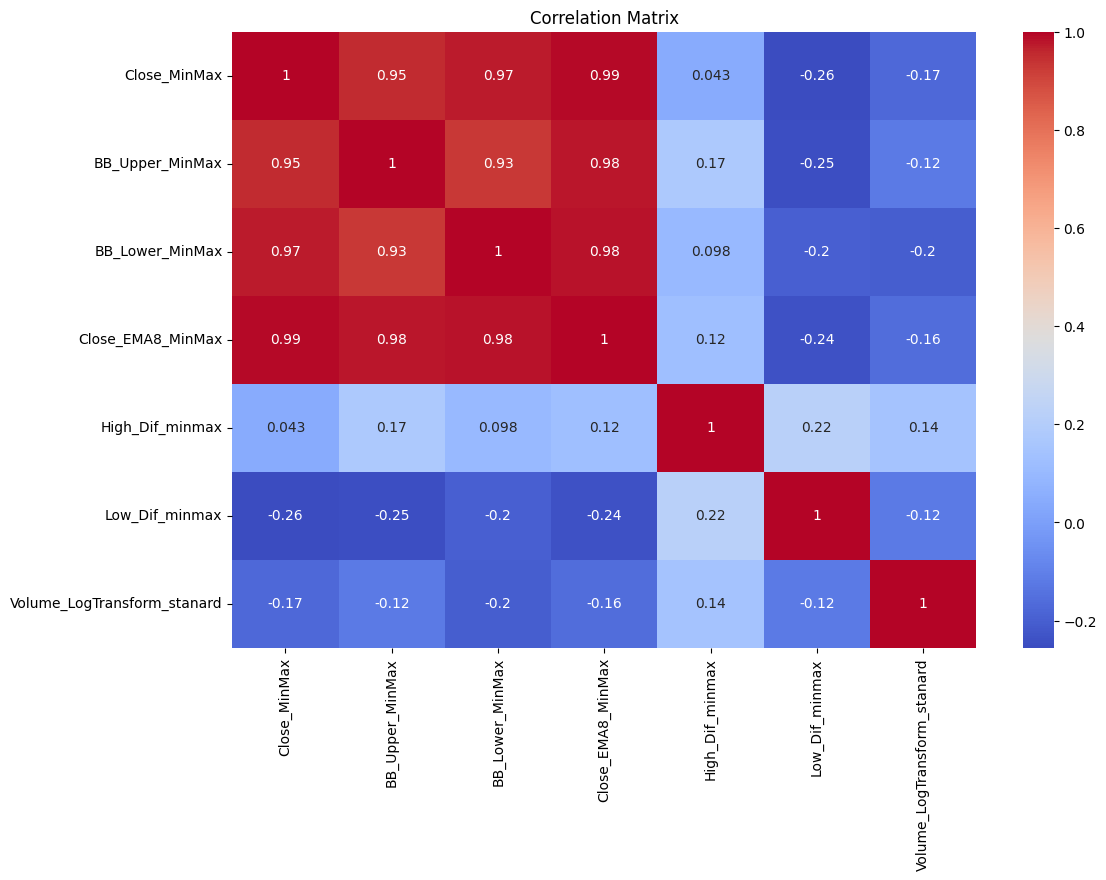

In [179]:
indexs1 = [
    'Close_MinMax',
    # 'Close_SavGol_MinMax',
    'BB_Upper_MinMax', 'BB_Lower_MinMax',
    'Close_EMA8_MinMax',
    # 'High_minmax', 'Low_minmax', 
    'High_Dif_minmax', 'Low_Dif_minmax',
    'Volume_LogTransform_stanard'
]
corr_matrix = processed[indexs1].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Sequence Creation

In [180]:
data_1= pd.DataFrame(index=df.index)
data_1[['Close',
    'BB_Upper', 'BB_Lower',
    'Close_EMA8',
    'High_Dif', 'Low_Dif',
    'Volume']] = processed[['Close_MinMax',
    'BB_Upper_MinMax', 'BB_Lower_MinMax',
    'Close_EMA8_MinMax',
    'High_Dif_minmax', 'Low_Dif_minmax',
    'Volume_LogTransform_stanard']]


In [181]:
def Test_train_validation(data,ratio_train=0.6, ratio_val=0):
    # Drop rows with missing values
    df_og = data.copy()
    df_og = df_og.dropna()
    df_og = df_og.sort_values('Date')
    # Calculate the split index
    split_idx1 = int(len(df_og) * ratio_train)
    train_df = df_og.iloc[:split_idx1]

    if ratio_val == 0 :
        test_df = df_og.iloc[split_idx1:]
        return train_df, test_df

    split_idx2 = int(len(df_og) * (ratio_train + ratio_val))

    val_df = df_og.iloc[split_idx1:split_idx2]
    test_df = df_og.iloc[split_idx2:]

    return train_df, val_df,test_df    


In [182]:
def Creat_sequence( data , input_length, output_length):
    sequences = []
    labels = []
    
    for i in range(len(data) - input_length - output_length + 1):
        sequence = data.iloc[i:i + input_length][
            ['Close',
            'BB_Upper', 'BB_Lower',
            'Close_EMA8',
            'High_Dif', 'Low_Dif',
            'Volume']
                ]
        label = data.iloc[i + input_length:
                          i + input_length + output_length][['Close']]
        
        sequences.append(sequence)
        labels.append(label)
    
    return np.array(sequences), np.array(labels)

In [183]:
n_input = int(360 * 0.1)
n_output = 1
Trains_split = 0.6
Valitaion_split = 0.2
#
train_data1, val_data1, test_data1 = Test_train_validation(data_1, Trains_split, Valitaion_split)

# Create sequences for training and validation
X_trn_seq1, y_trn_seq1 = Creat_sequence(train_data1, n_input, n_output)
X_val_seq1, y_val_seq1 = Creat_sequence(val_data1, n_input, n_output)
X_tst_seq1, y_tst_seq1 = Creat_sequence(test_data1, n_input, n_output)

In [184]:
X_trn_seq1.shape, y_trn_seq1.shape, X_val_seq1.shape, y_val_seq1.shape, X_tst_seq1.shape, y_tst_seq1.shape

((263, 36, 7), (263, 1, 1), (64, 36, 7), (64, 1, 1), (64, 36, 7), (64, 1, 1))

Modeling

In [194]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import Input, Model
from tensorflow.keras.metrics import MeanSquaredError

# Create a deep learning model for time series prediction
def Creat_model(input_length, input_features, output_length,
                optimizer1=Adam(learning_rate=0.001), 
                loss1='mse',metrics1=['mae']):
    #[MeanSquaredError(), RootMeanSquaredError()]):
    
    # Build the model
    input_layer = Input(shape=(input_length, input_features), name="Input_Layer")  
    X = Bidirectional(LSTM(50, return_sequences=True), name="BI_LSTM_Layer1") (input_layer) 
    X = Dropout(0.2, name="Dropout1")(X)  # Prevent overfitting
    X = Bidirectional(LSTM(50, return_sequences=False), name="BI_LSTM_Layer2")(X)  # Final GRU output
    X = Dropout(0.2, name="Dropout2")(X)
    X = Dense(25, activation='relu', name="Dense_Layer")(X)
    output_layer = Dense(output_length, name="Output_Layer")(X)
    
    # Create the model
    model1 = Model(inputs=input_layer, outputs=output_layer) 
    # Compile the model
    model1.compile(optimizer=optimizer1, loss=loss1 ,    metrics=metrics1 ) 
    return model1

In [ ]:
n_input1 = X_trn_seq1.shape[1]
n_feature1= X_trn_seq1.shape[2]
n_output1 = y_trn_seq1.shape[2]

model3 = Creat_model(n_input1, n_feature1, n_output1, optimizer1='adam',
                       loss1='mse', metrics1=[MeanSquaredError()])
# Callbacks
early_stopping = EarlyStopping(
                        monitor='val_loss', patience=10, restore_best_weights=True
                    )
reduce_lr = ReduceLROnPlateau(
                        monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001
                    )
checkpoint = ModelCheckpoint(
    'best_model.h5',                # Filepath to save the model
    monitor='val_loss',             # Monitor validation loss
    save_best_only=True,            # Only save when val_loss improves
    mode='min',                     # Lower val_loss is better
    verbose=1
)
callbacks1 = [checkpoint, early_stopping, reduce_lr]    


Epoch 1/8

Epoch 1: val_loss improved from inf to 0.04971, saving model to best_model.h5
9/9 - 4s - loss: 0.0172 - mean_squared_error: 0.0172 - val_loss: 0.0497 - val_mean_squared_error: 0.0497 - lr: 0.0010 - 4s/epoch - 428ms/step
Epoch 2/8

Epoch 2: val_loss improved from 0.04971 to 0.02325, saving model to best_model.h5
9/9 - 0s - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - lr: 0.0010 - 228ms/epoch - 25ms/step
Epoch 3/8

Epoch 3: val_loss did not improve from 0.02325
9/9 - 0s - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - lr: 0.0010 - 189ms/epoch - 21ms/step
Epoch 4/8

Epoch 4: val_loss did not improve from 0.02325
9/9 - 0s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0253 - val_mean_squared_error: 0.0253 - lr: 0.0010 - 187ms/epoch - 21ms/step
Epoch 5/8

Epoch 5: val_loss improved from 0.02325 to 0.01896, saving model to best_model.h5
9/9 - 0s - loss: 0.0034 - mean_squa

In [ ]:

# Train model
history1 = model3.fit(
    X_trn_seq1, y_trn_seq1,
    epochs=8, 
    # batch_size=1024,
    validation_data=(X_val_seq1, y_val_seq1),
    verbose=2,
    callbacks=callbacks1
)

In [196]:
# plot and acutal input and given output
def plot_his(history, start_epoch=0):
    filds = history.history.keys()
    plt.figure(figsize=(12, 8))
    if 'loss' in filds:
    # Loss
        plt.subplot(2, 2, 1)
        plt.plot(range(start_epoch, len(history.history['loss'])), 
             history.history['loss'][start_epoch:], 
             label='Train Loss')
        if 'val_loss' in filds:
            plt.plot(range(start_epoch, len(history.history['val_loss'])), 
             history.history['val_loss'][start_epoch:], 
             label='Validation Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

    if 'mean_squared_error' in filds:
        # MSE
        plt.subplot(2, 2, 2)
        plt.plot(range(start_epoch, len(history.history['mean_squared_error'])), 
             history.history['mean_squared_error'][start_epoch:], 
             label='Train MSE')
        if 'val_mean_squared_error' in filds:
            plt.plot(range(start_epoch, len(history.history['val_mean_squared_error'])), 
             history.history['val_mean_squared_error'][start_epoch:], 
             label='Validation MSE')
        plt.title('MSE over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('MSE')
        plt.legend()

    if 'root_mean_squared_error' in filds:
    # RMSE
        plt.subplot(2, 2, 3)
        plt.plot(range(start_epoch, len(history.history['root_mean_squared_error'])), 
             history.history['root_mean_squared_error'][start_epoch:], 
             label='Train RMSE')
        if 'val_root_mean_squared_error' in filds:
            plt.plot(range(start_epoch, len(history.history['val_root_mean_squared_error'])), 
             history.history['val_root_mean_squared_error'][start_epoch:], 
             label='Validation RMSE')
        plt.title('RMSE over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('RMSE')
        plt.legend()

    plt.tight_layout()
    plt.show()

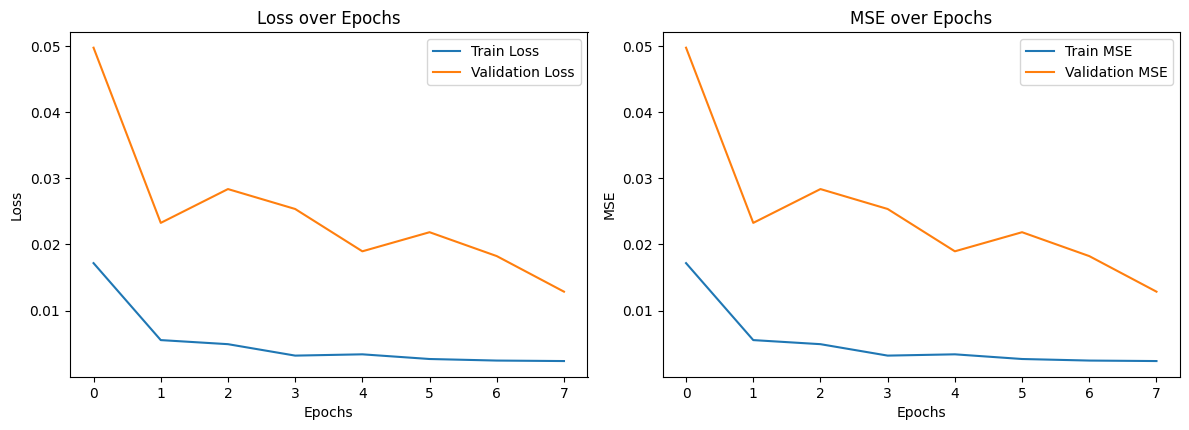

In [197]:
plot_his(history1,0)

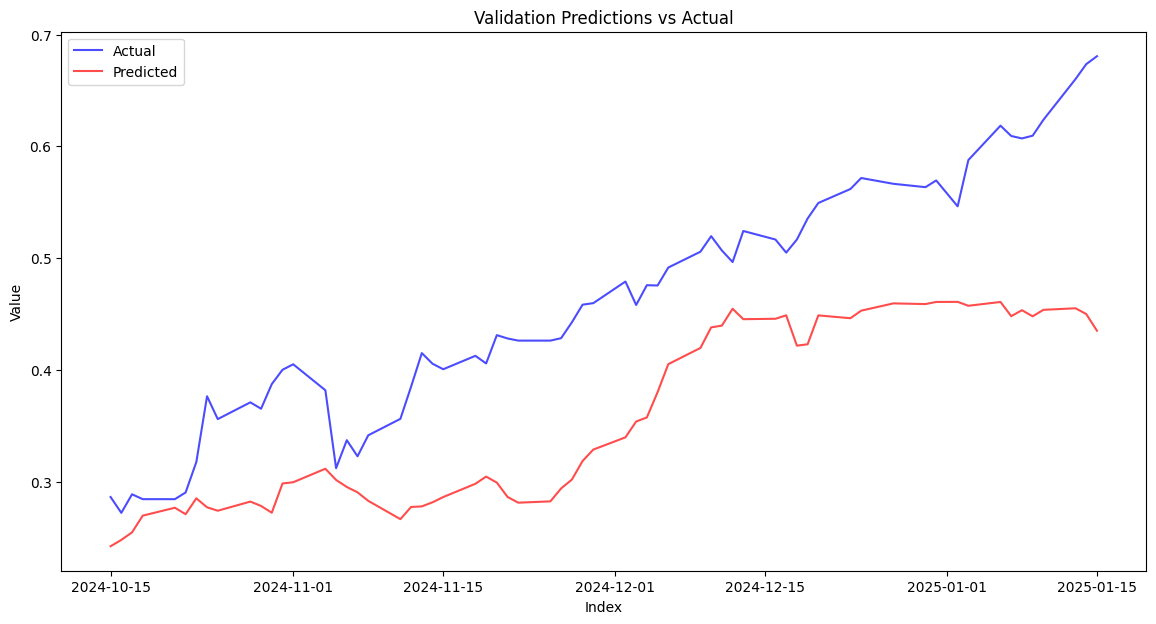

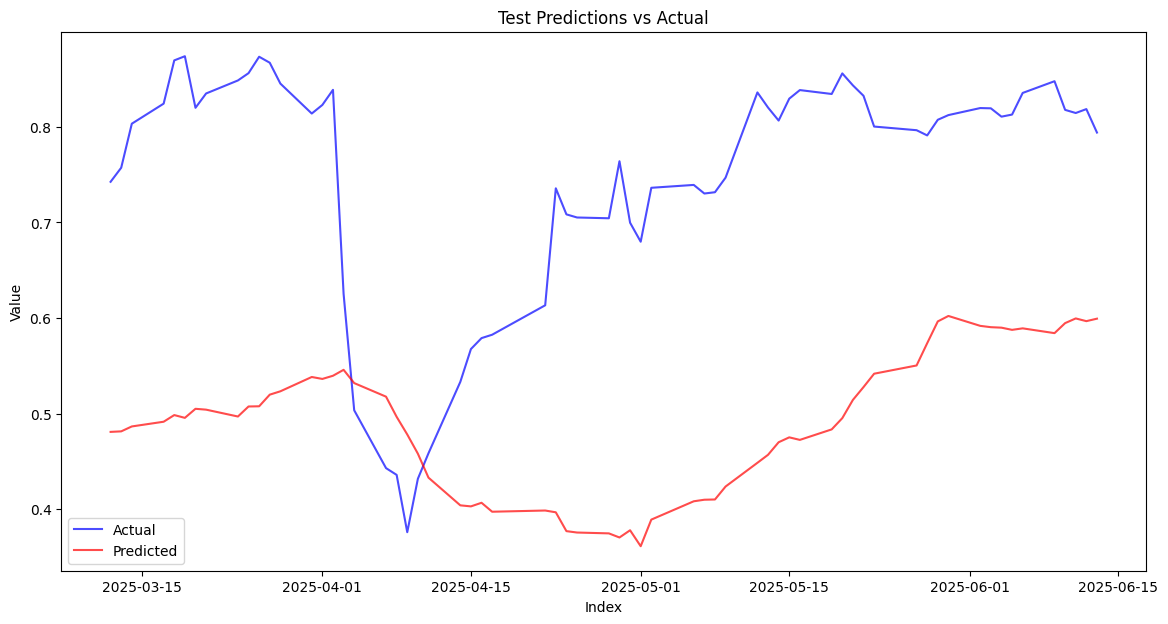

In [225]:
Val_pred = model3.predict(X_val_seq1, verbose=0)
test_pred = model3.predict(X_tst_seq1, verbose=0)

split_idx1 = int(len(df) * Trains_split)
split_idx2 = int(len(df) * (Trains_split + Valitaion_split))
####
def plot_predictions(y_true, y_pred, indexs, title='Predictions vs Actual'):
    # Flatten arrays to 1D
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    plt.figure(figsize=(14, 7))
    plt.plot(indexs, y_true, label='Actual', color='blue', alpha=0.7)
    plt.plot(indexs, y_pred, label='Predicted', color='red', alpha=0.7)
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


# Val_pred.shape, test_pred.shape, y_val_seq1.shape, y_tst_seq1.shape,len(df) - split_idx2-n_input-2,len(df),
plot_predictions(y_val_seq1, Val_pred,df[split_idx1+n_input+1:split_idx2-1].index , title='Validation Predictions vs Actual')
plot_predictions(y_tst_seq1, test_pred,df[split_idx2+n_input+2:].index , title='Test Predictions vs Actual')